In [4]:
import os,sys
import numpy as np
import scipy as sp
import pandas as pd
from datetime import datetime, timedelta, time
import learning_lidar.utils.global_settings as gs
import pandas as pd
import learning_lidar.preprocessing.preprocessing as prep
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline
from learning_lidar.generation.daily_signals_generations_utils import calc_r2_ds,get_daily_bg
import learning_lidar.generation.generation_utils as gen_utils
from learning_lidar.dataseting.dataseting import calc_data_statistics

from tqdm import tqdm
gs.set_visualization_settings()

In [5]:
def daily_ds_histogram(dataset, profile_type='range_corr',
                       nbins=100, log_scale=False,
                       SAVE_FIG = False , dst_folder = os.path.join ( '..' , 'Figures' )
                       , format_fig = 'png'):
    date_datetime = prep.get_daily_ds_date ( dataset )
    ds_profile = dataset.get(profile_type)
    df_stats = pd.DataFrame(columns=['wavelength [nm]', 'valid size %',
                                     'positive %', 'negative %','zeros %',
                                     'mean' , 'std'])
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6),sharey=True)
    ax = axes
    th = gs.eps
    for ind,(wavelength) in enumerate(dataset.Wavelength.values):
        sub_ds = ds_profile.sel(Wavelength = wavelength)
        mask_valid = (~pd.isna(sub_ds.values))
        valid_size = mask_valid.astype(int).sum()
        orig_size = sub_ds.values.size

        # positive values histogram
        pos_ds = sub_ds.where(sub_ds > th).where(sub_ds != np.nan)#.values
        pos_vals = pos_ds.values[~np.isnan(pos_ds.values)]
        pos_size = pos_vals.size

        hist, bins =np.histogram(pos_vals , bins=nbins)
        min_bin = bins[0] if bins[0]>0 else bins[0]+gs.eps
        max_bin = bins[-1]
        logbins = np.logspace(np.log10(min_bin),np.log10(max_bin),len(bins))
        ax.hist(pos_vals, bins=logbins, label = f"$\lambda={wavelength}$",
                   alpha=0.4)

        if log_scale:
            ax.set_xscale('symlog')

        #negative values histogram
        neg_ds = sub_ds.where(sub_ds < -th).where(sub_ds != np.nan )#.values
        neg_vals= neg_ds.values[~np.isnan(neg_ds.values)]
        neg_size = neg_vals.size


        # Zero values histogram
        zero_ds= sub_ds.where(sub_ds >= -th).where(sub_ds <=th).where(sub_ds != np.nan )
        zero_vals= zero_ds.values[~np.isnan(zero_ds.values)]
        zero_size = zero_vals.size

        df_stats.loc[ind] = [wavelength,
                            100.0*valid_size/orig_size,
                            100.0*pos_size/orig_size ,
                            100.0*neg_size/orig_size ,
                            100.0*zero_size/orig_size,
                            sub_ds.mean().values,
                            sub_ds.std().values]
        # TODO : take care of representation after the digit values

    ax.legend()
    min_val, max_val = float(ds_profile.min().values),float(ds_profile.max().values)
    ax.set_xlim([min_val,max_val+0.1*(max_val-min_val)])
    ax.set_ylabel('counts')
    ax.tick_params(axis='both', which='major')

    xlabels = f"{ds_profile.long_name} [{ds_profile.units}]"
    ax.set_xlabel(xlabels, horizontalalignment='center')
    axes.ticklabel_format(axis='y', style="sci",scilimits=(0,0))
    stitle = f"Histogram of {ds_profile.info.lower()} " \
             f"\n {dataset.attrs['location']} {date_datetime.strftime('%Y-%m-%d')}"
    fig.suptitle(stitle)

    plt.tight_layout()
    plt.show()

    if SAVE_FIG :
        fname = f"{date_datetime.strftime ( '%Y-%m-%d' )}_{dataset.attrs ['location']}_{profile_type}_" \
                f"source_{dataset.attrs['source_type']}_histogram.{format_fig}"
        if not os.path.exists ( dst_folder ) :
            try :
                os.makedirs ( dst_folder , exist_ok = True )
                print (f"Creating folder: {dst_folder}") # logger.debug ( f"Creating folder: {dst_folder}" )
            except Exception :
                raise OSError ( f"Failed to create folder: {dst_folder}" )
        fpath = os.path.join ( dst_folder , fname )
        fig.savefig(fpath,bbox_inches='tight', format = format_fig)
        print(f"Figure saved at {fpath}") # logger.debug ( f"Figure saved at {fpath}" )
    return fig,axes,df_stats

In [8]:
station_name = 'haifa'
station = gs.Station(station_name)
wavelengths = gs.LAMBDA_nm().get_elastic()
dates = [datetime(2017,9,1), datetime(2017,9,2),datetime(2017,10,2),datetime(2017,10,15)]
dt_day = dates[0]
r2_da = calc_r2_ds(station, dt_day)
main_folder = os.path.dirname(os.path.abspath(os.path.curdir))
data_folder = os.path.join(os.path.dirname(os.path.abspath(os.path.curdir)), 'data')

'C:\\Users\\addalin\\Dropbox\\Lidar\\lidar_learning\\data'

# 1. Background signal

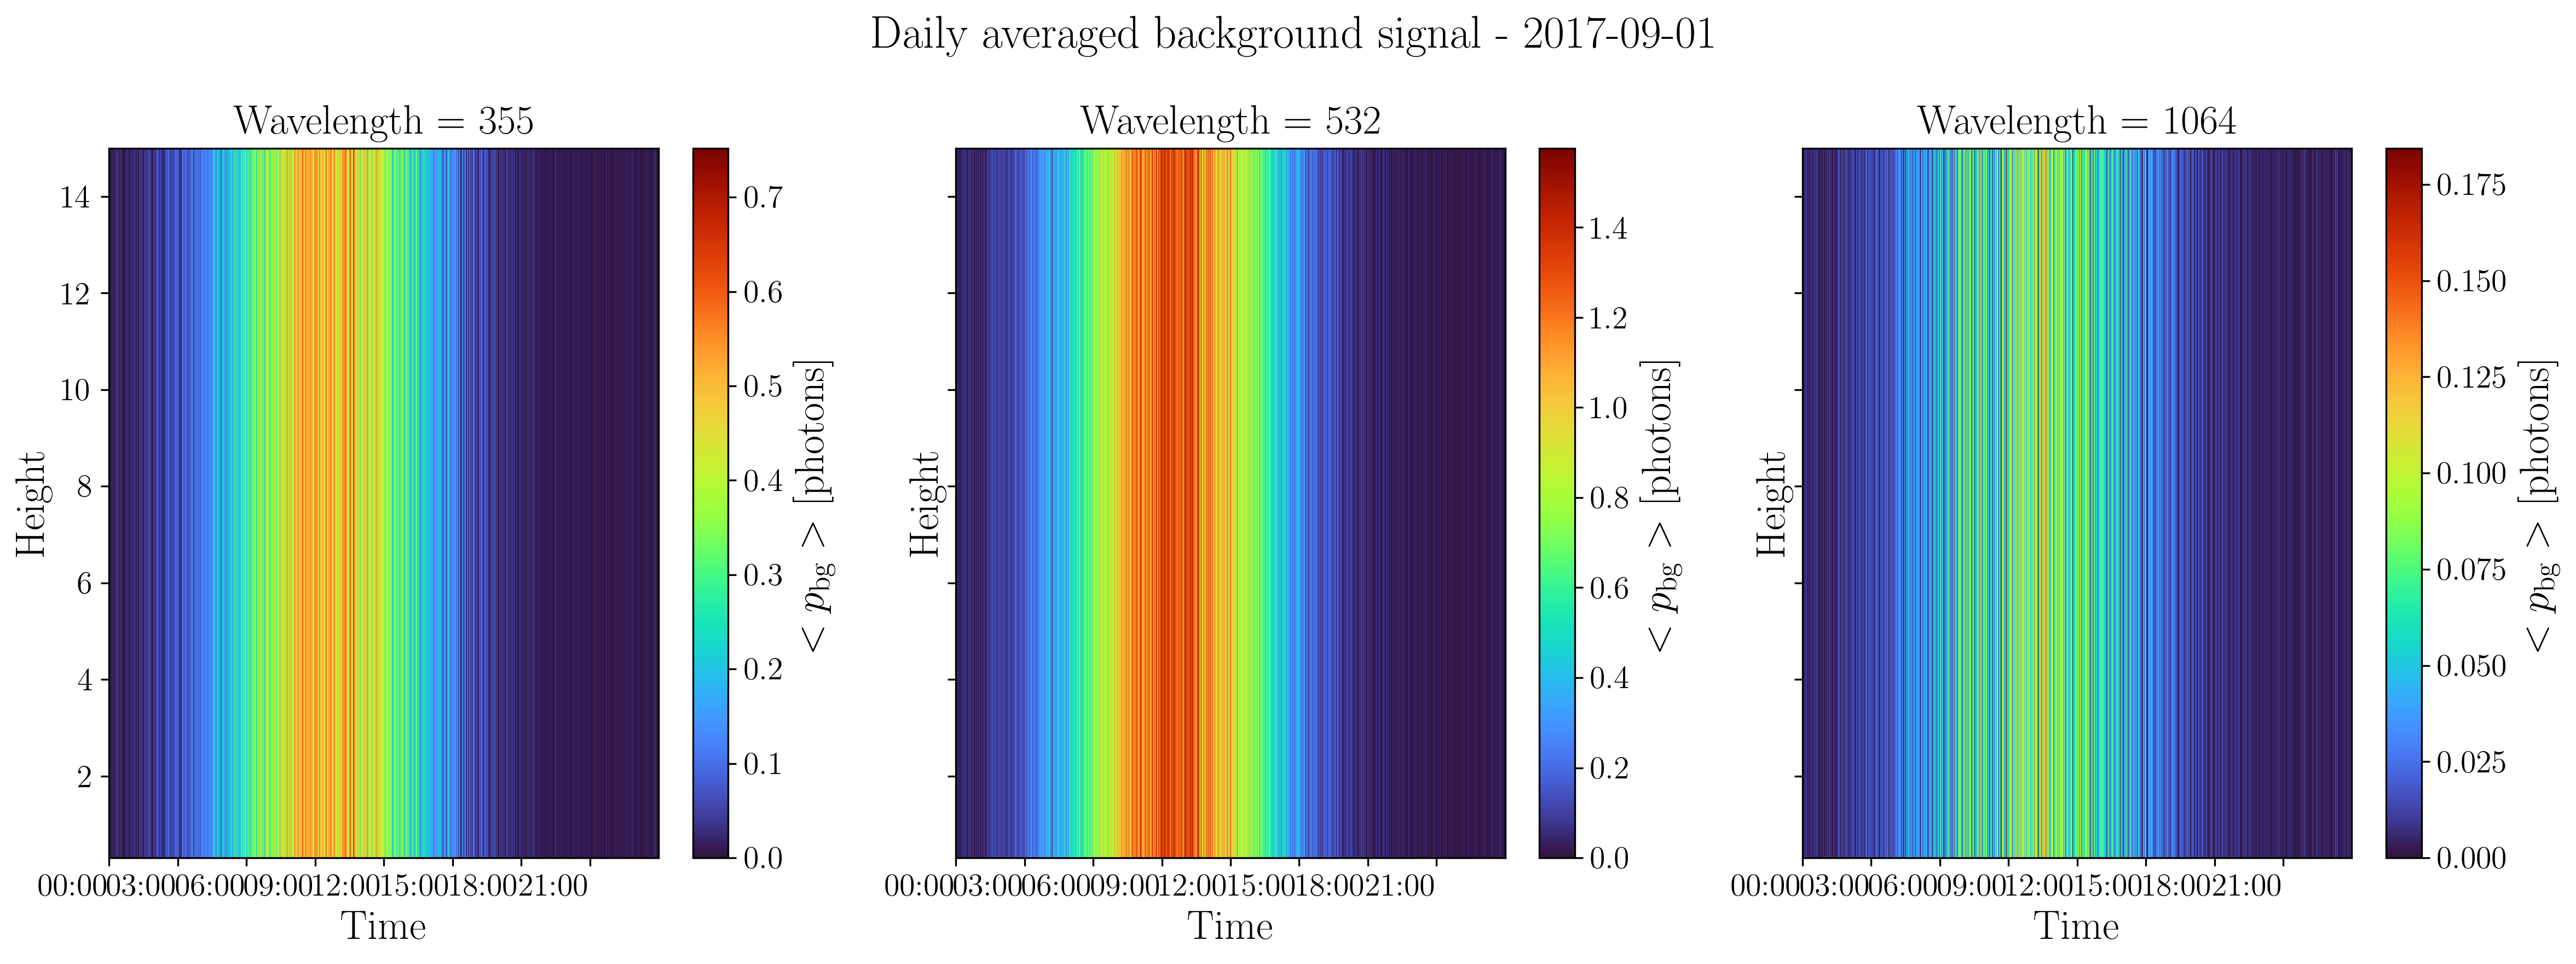

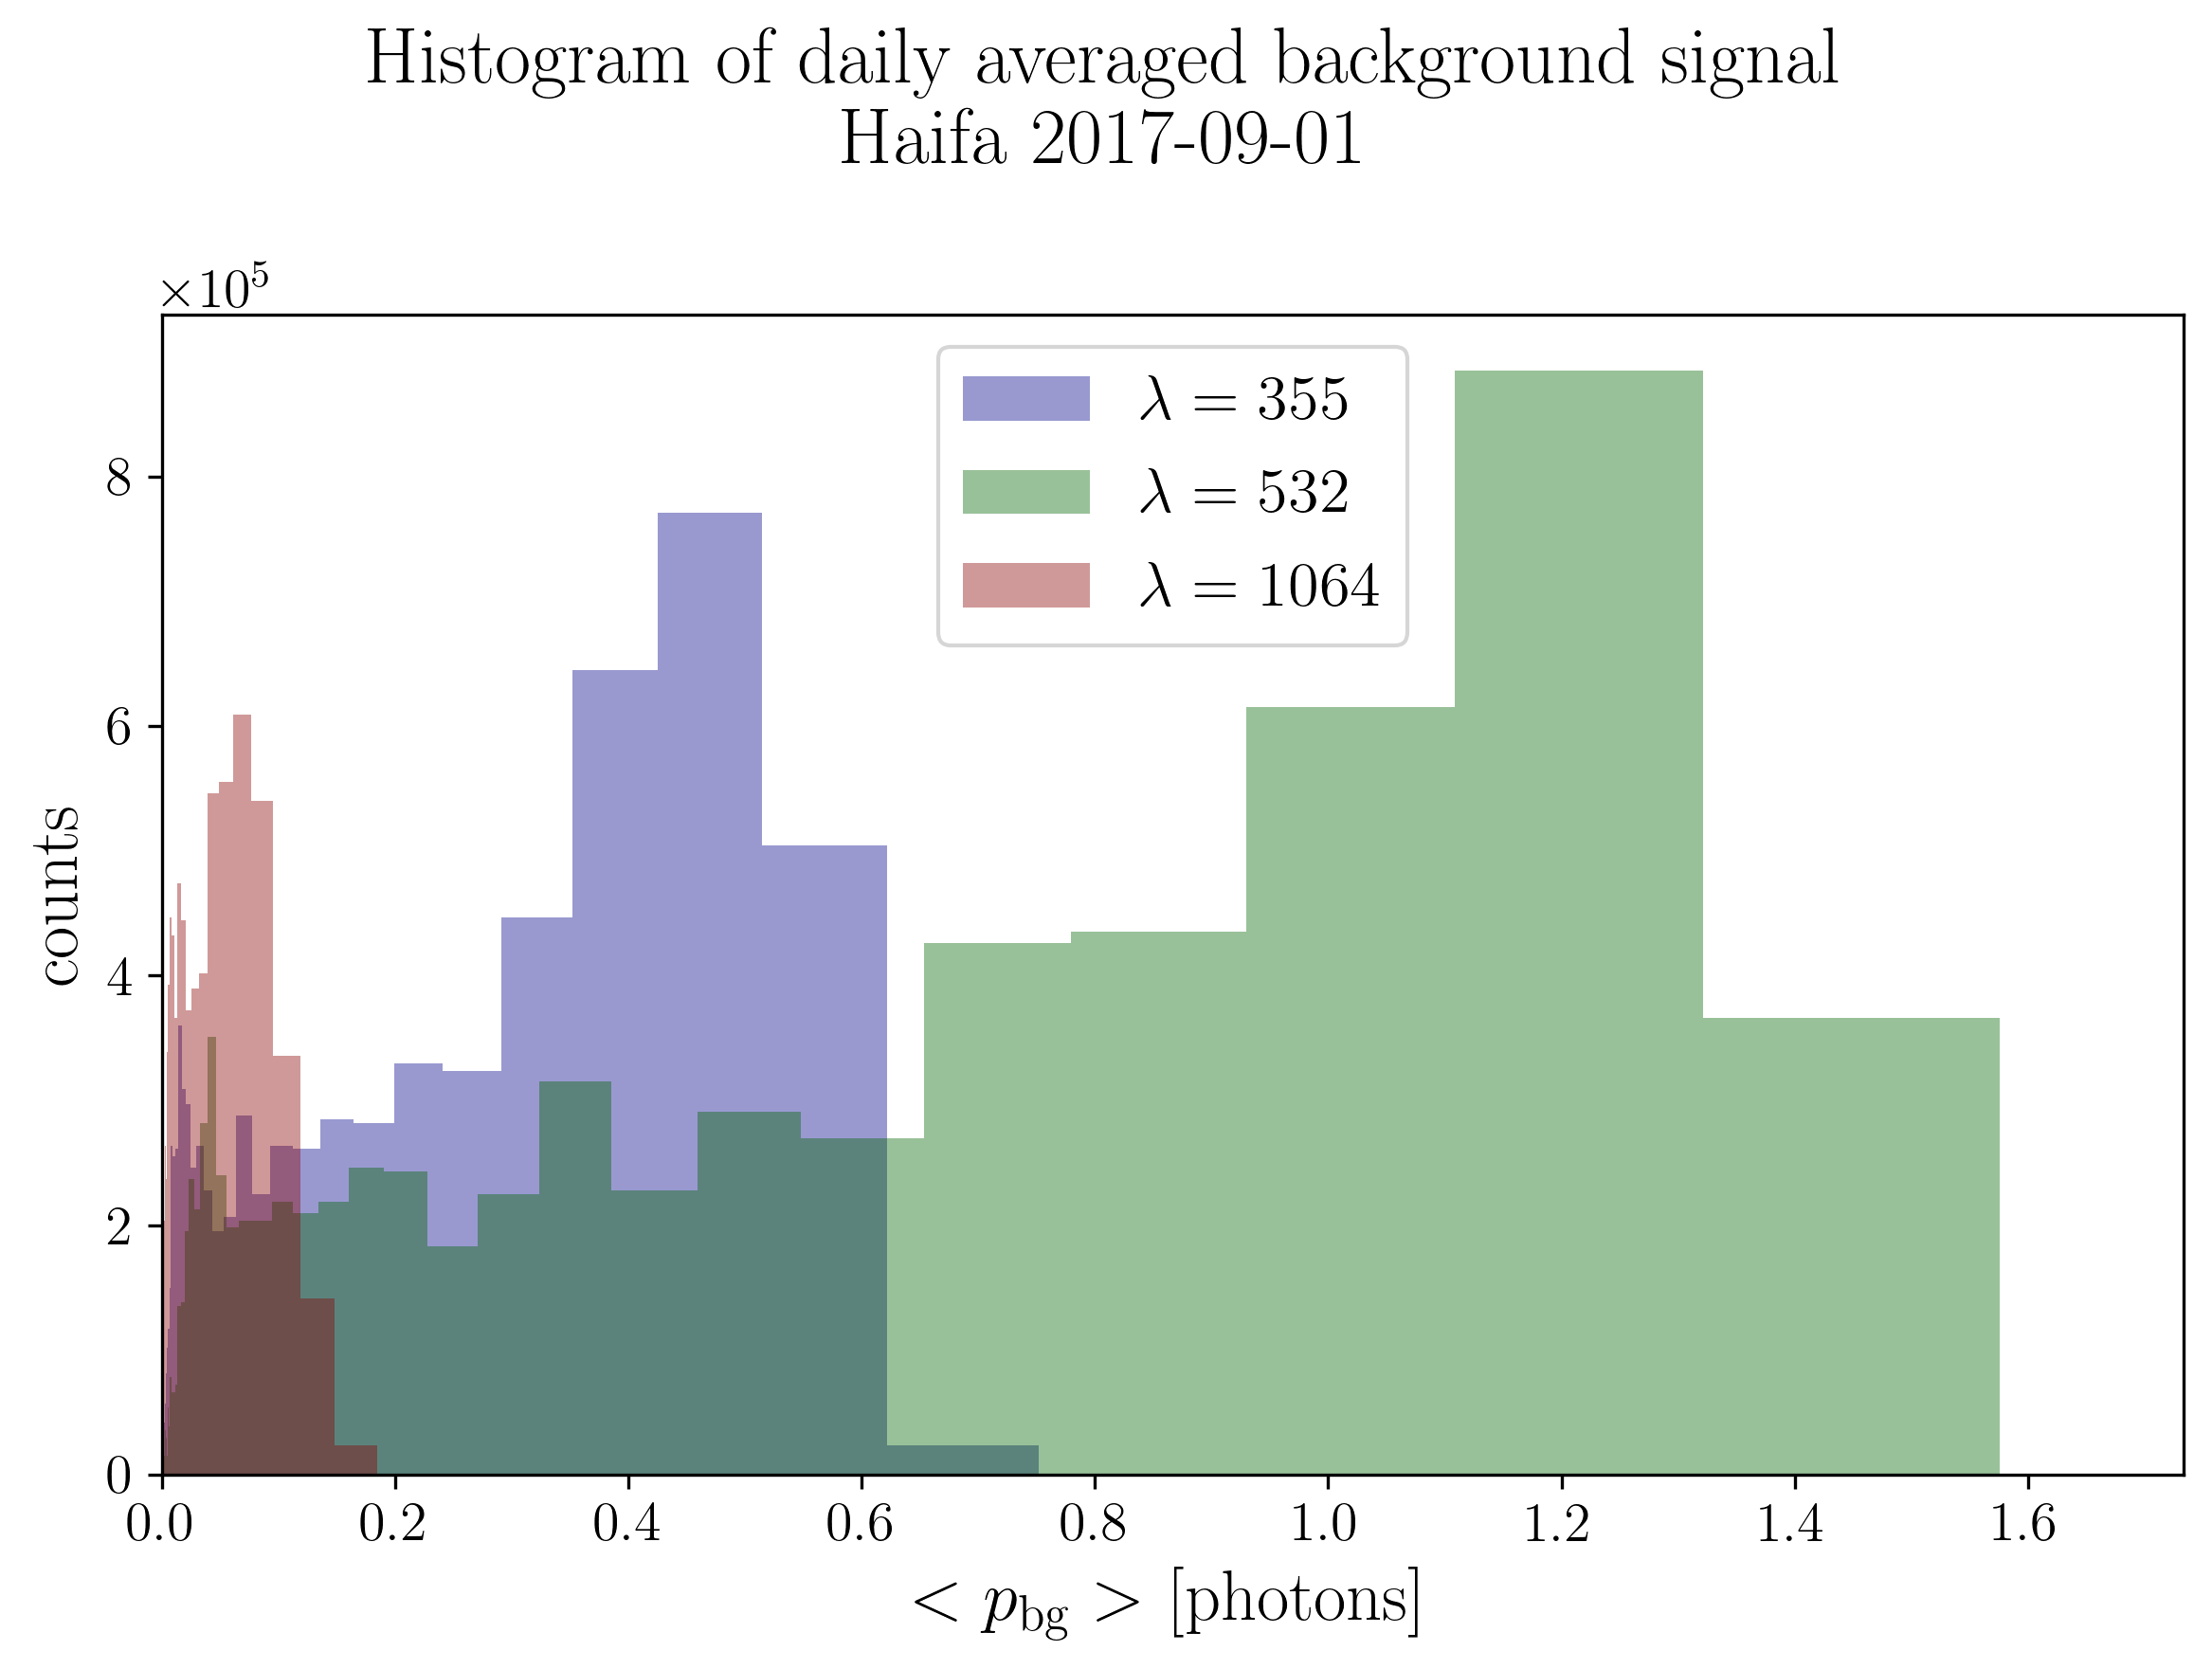

wavelength [nm]  valid size %  positive %  negative %   zeros %  \
0             355         100.0   95.451389         0.0  4.548611   
1             532         100.0   96.111111         0.0  3.888889   
2            1064         100.0   92.500000         0.0  7.500000   

                   mean                   std  
0   0.17105495972849938   0.18464141167146314  
1   0.44045429018407084   0.46370758959723335  
2  0.030882163023154965  0.032914838230055955

In [6]:
p_bg = get_daily_bg(station, dt_day)  # daily background: p_bg
# Expand p_bg to coordinates : 'Wavelength','Height', 'Time
bg_ds = p_bg.broadcast_like(r2_da).to_dataset()
bg_ds['date'] = dt_day
bg_ds.attrs['location'] = station.location

gen_utils.plot_daily_profile(bg_ds.bg,height_slice=slice(0,15), figsize=(16,6))
_,_,bg_stats= daily_ds_histogram(bg_ds, profile_type='bg',nbins=50)
bg_stats

# 2. Clean Lidar Signal

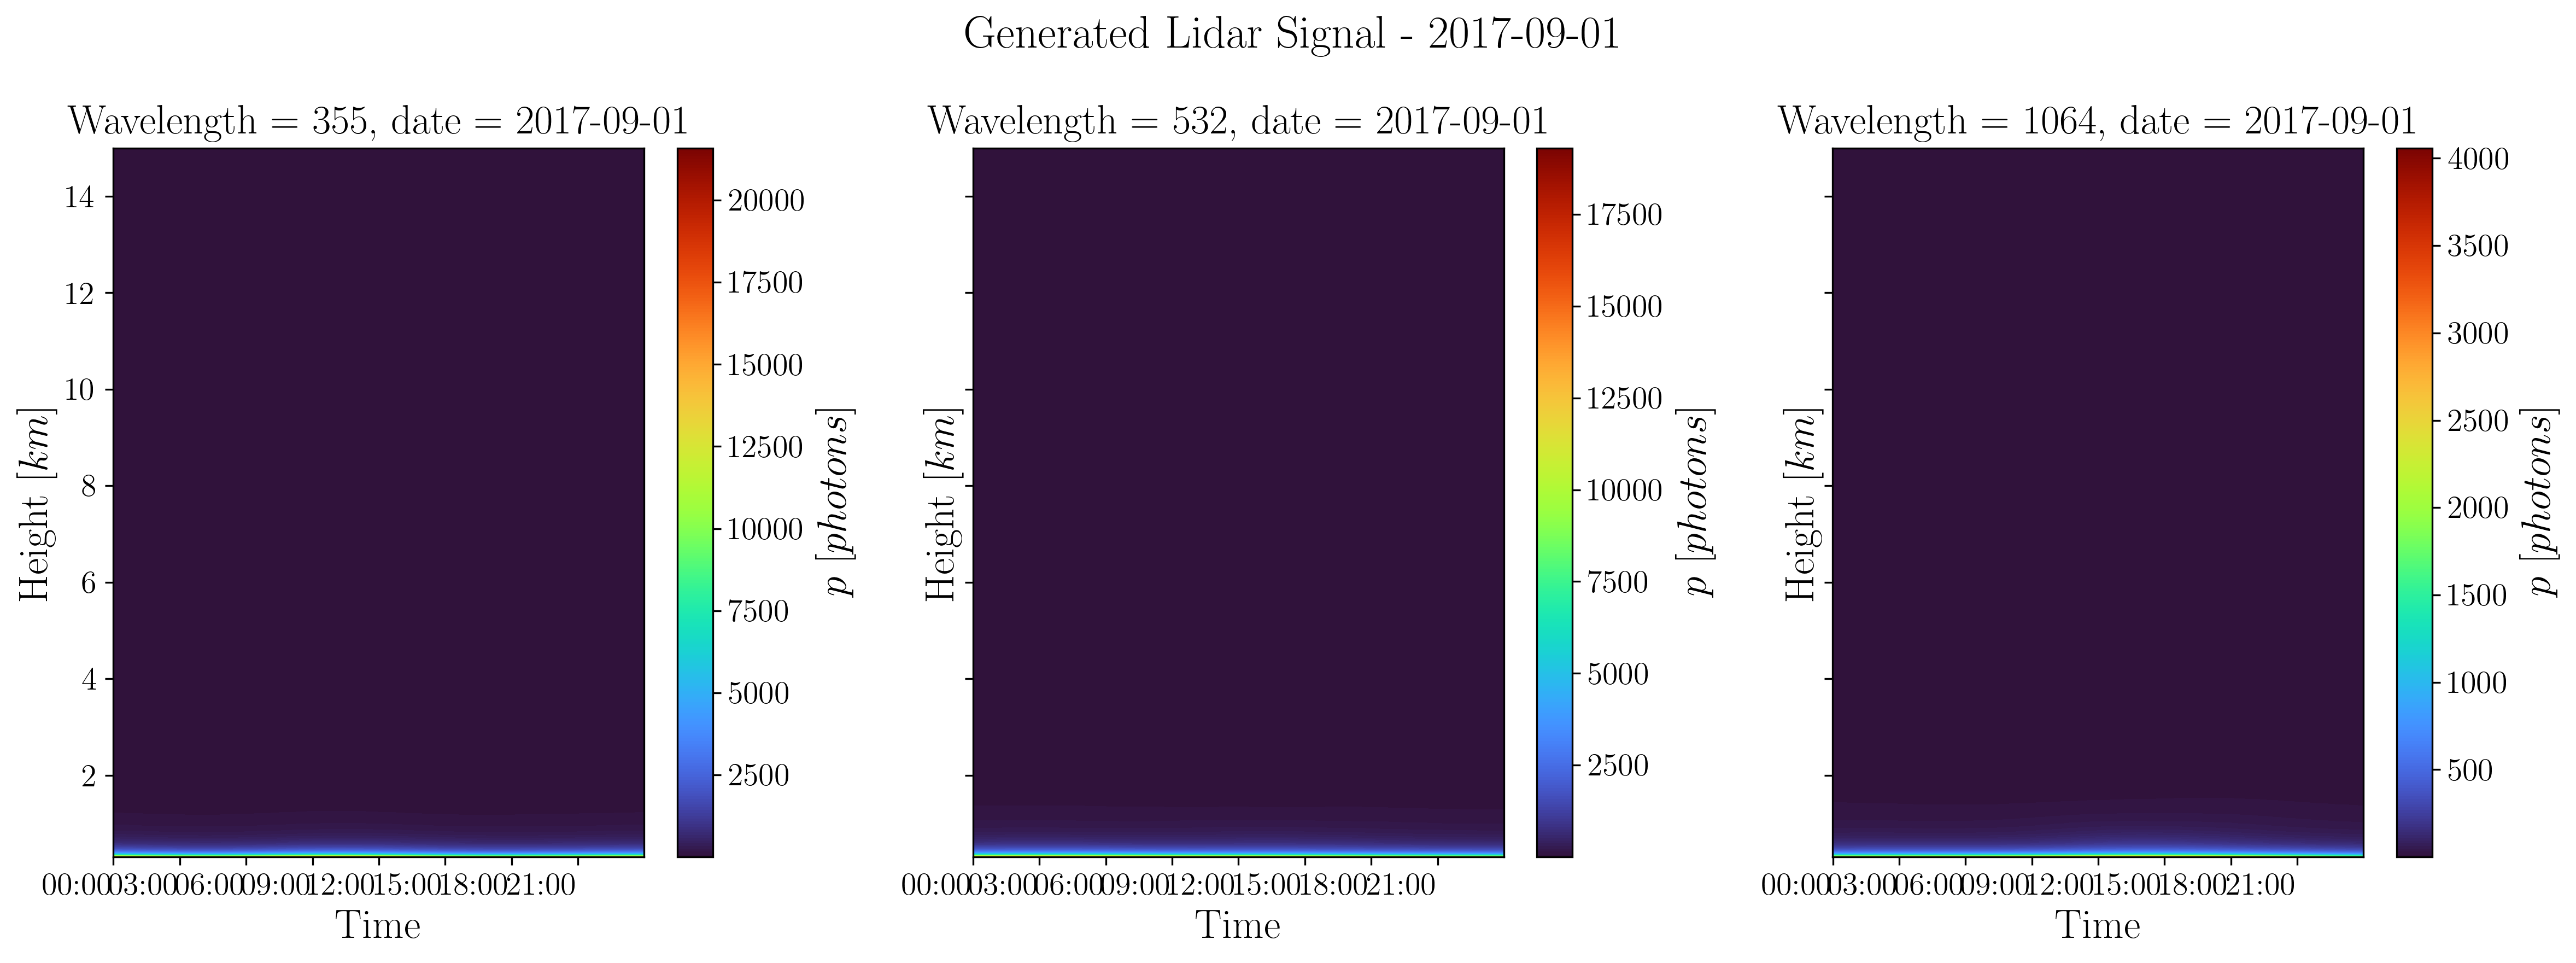

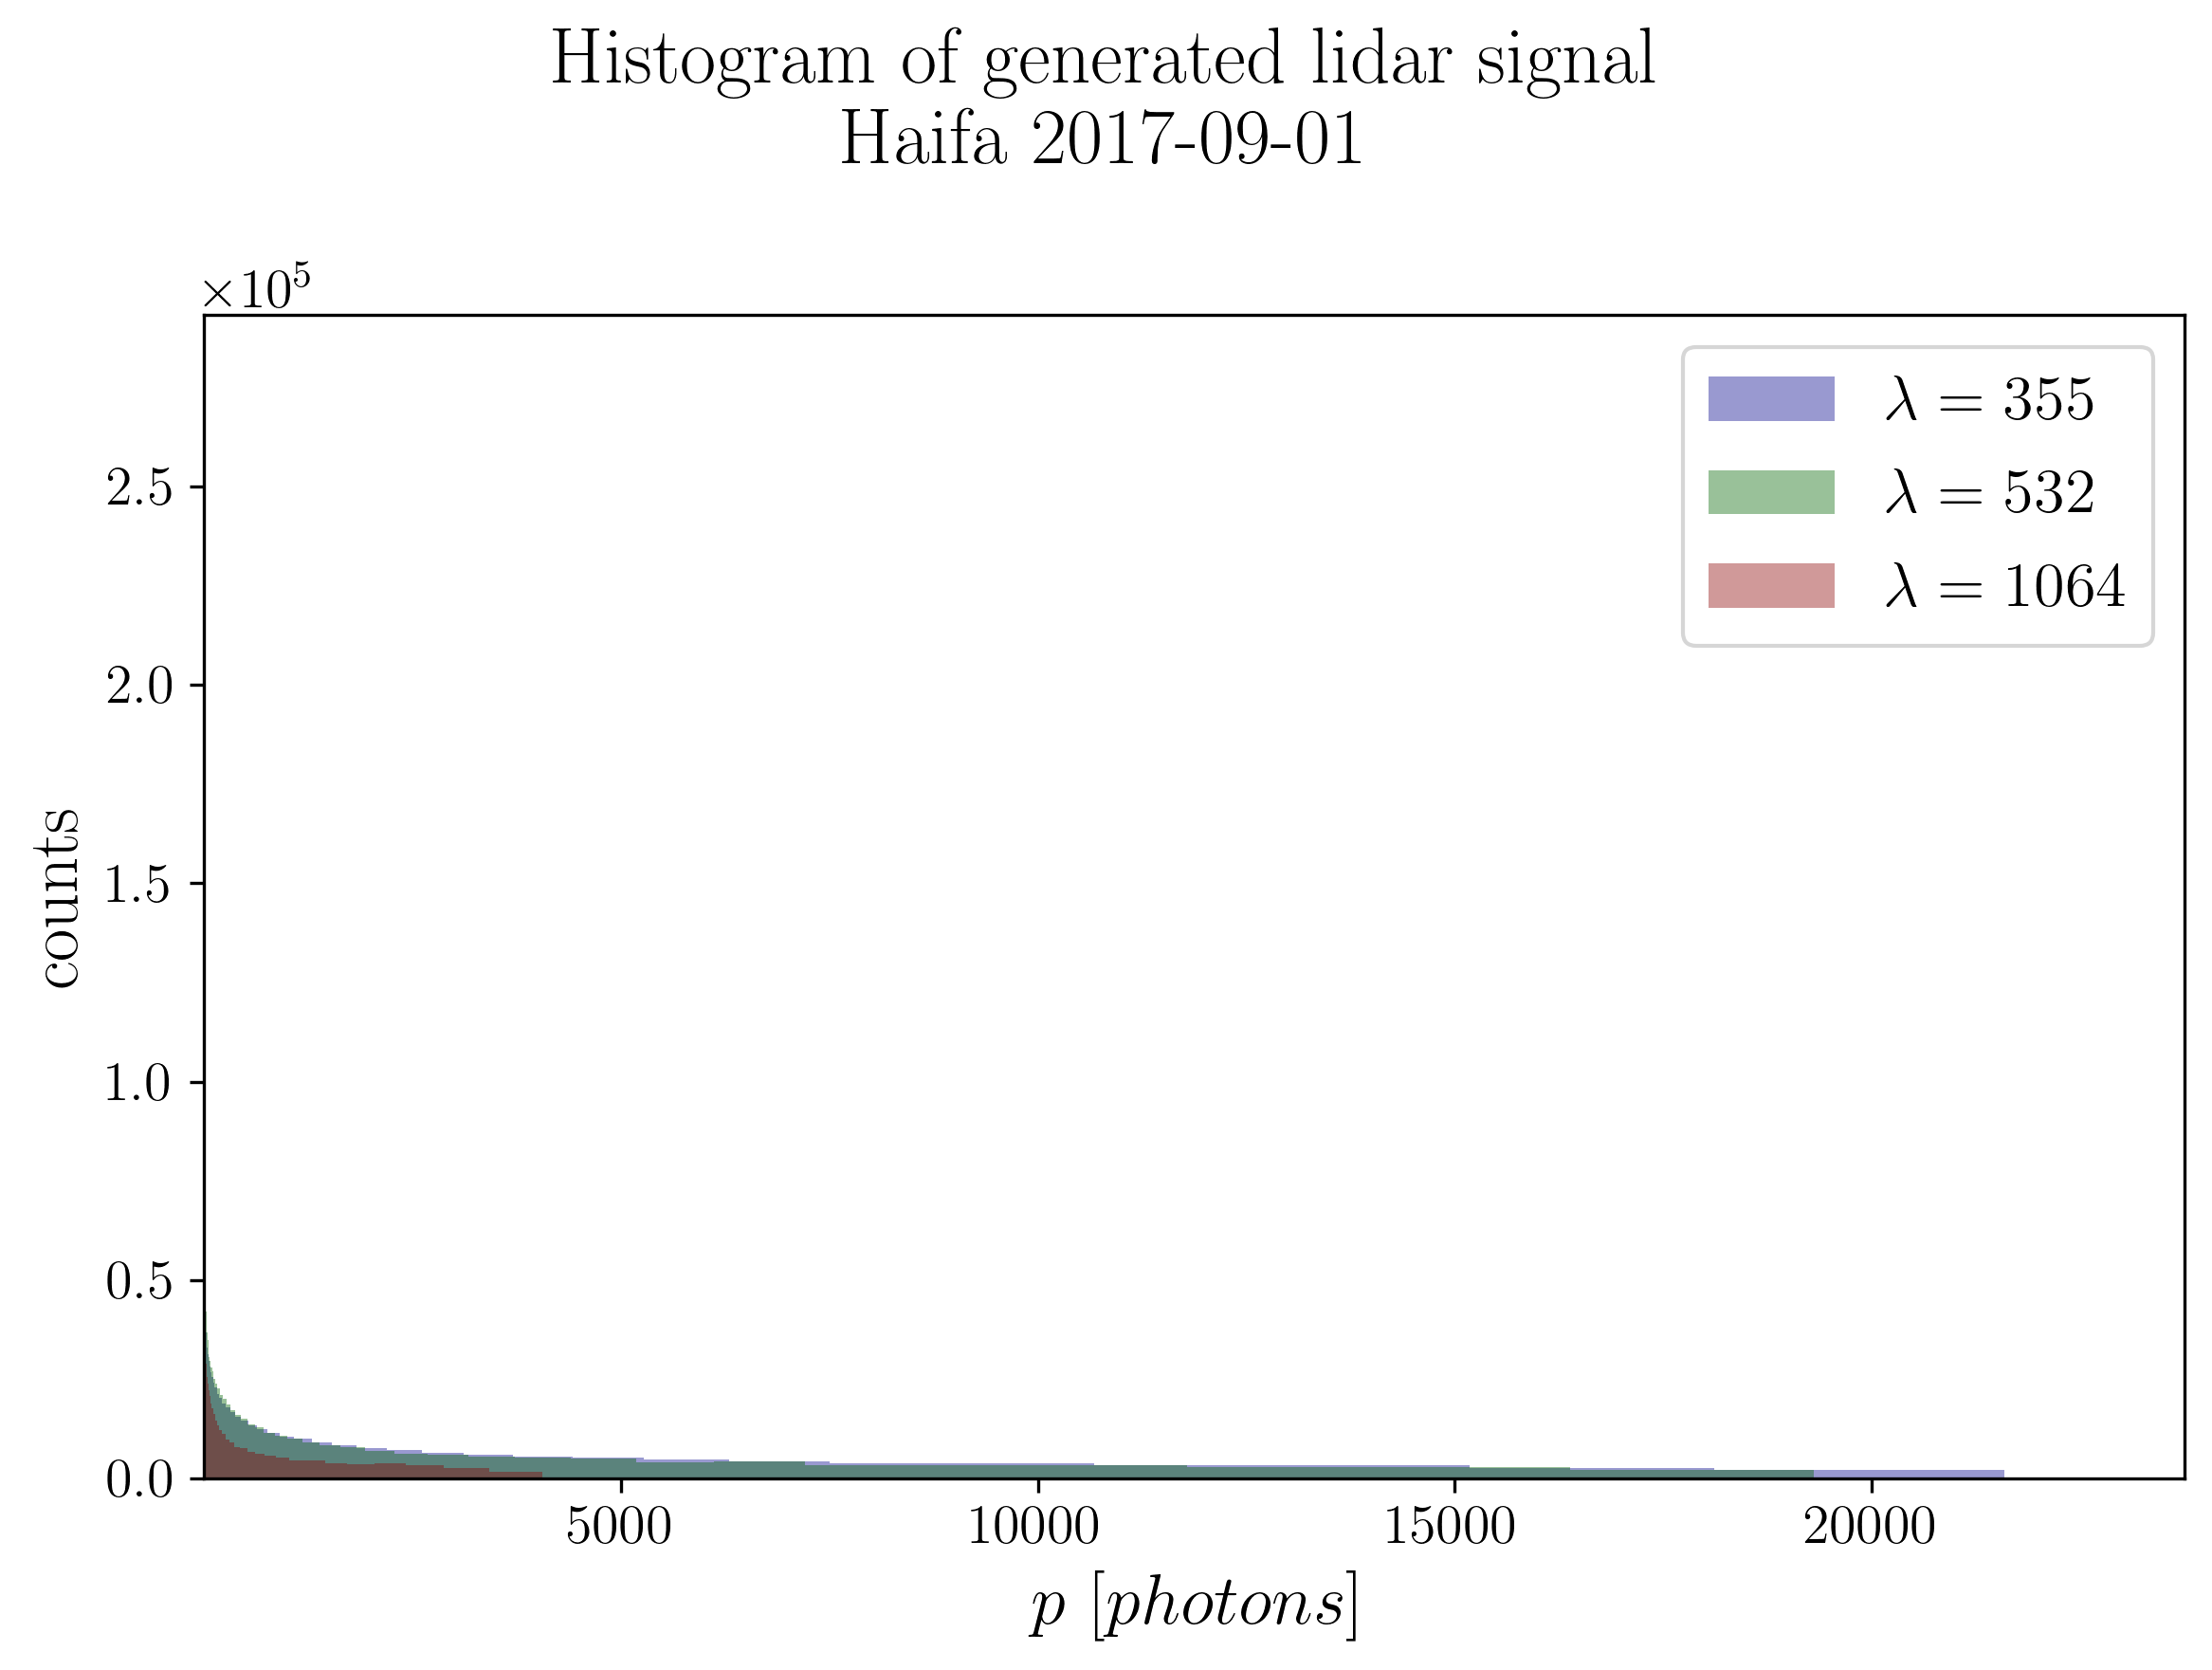

wavelength [nm]  valid size %  positive %  negative %  zeros %  \
0             355         100.0       100.0         0.0      0.0   
1             532         100.0       100.0         0.0      0.0   
2            1064         100.0       100.0         0.0      0.0   

                 mean                 std  
0   63.99917718385787   689.5392982269543  
1  61.317564028058214   632.9419572292697  
2  13.288489075004737  131.02730428310028

In [7]:
signal_folder = prep.get_month_folder_name(station.gen_signal_dataset,dt_day)
signal_nc_name = os.path.join(signal_folder,
                             gen_utils.get_gen_dataset_file_name(station,dt_day,data_source='signal'))
signal_ds = prep.load_dataset(signal_nc_name)
gen_utils.plot_daily_profile(signal_ds.p,height_slice=slice(0,15), figsize=(16,6))
_,_,p_stats= daily_ds_histogram(signal_ds, profile_type='p')#,log_scale=True)
p_stats

# 3. Lidar measurement

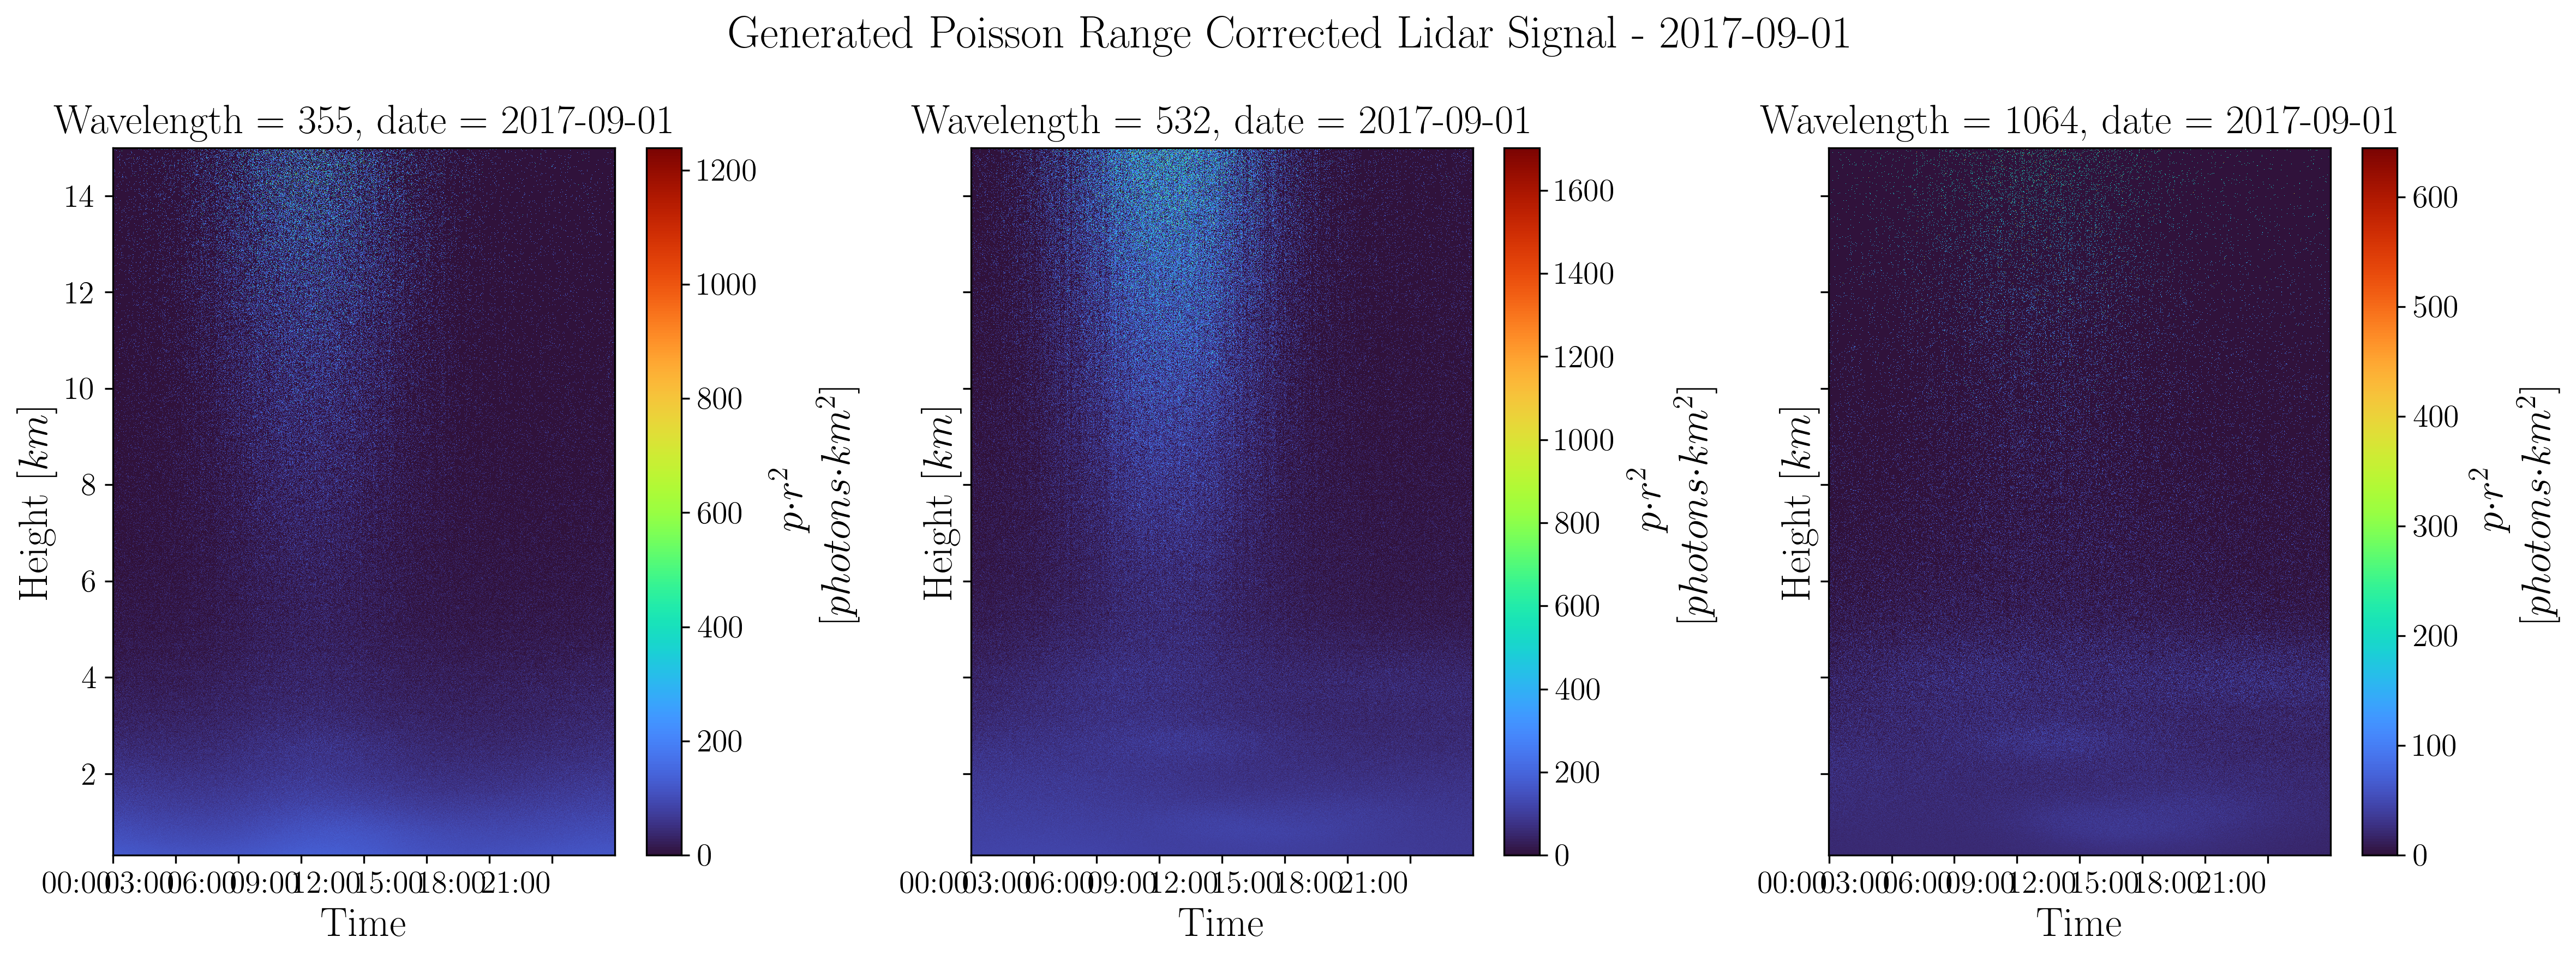

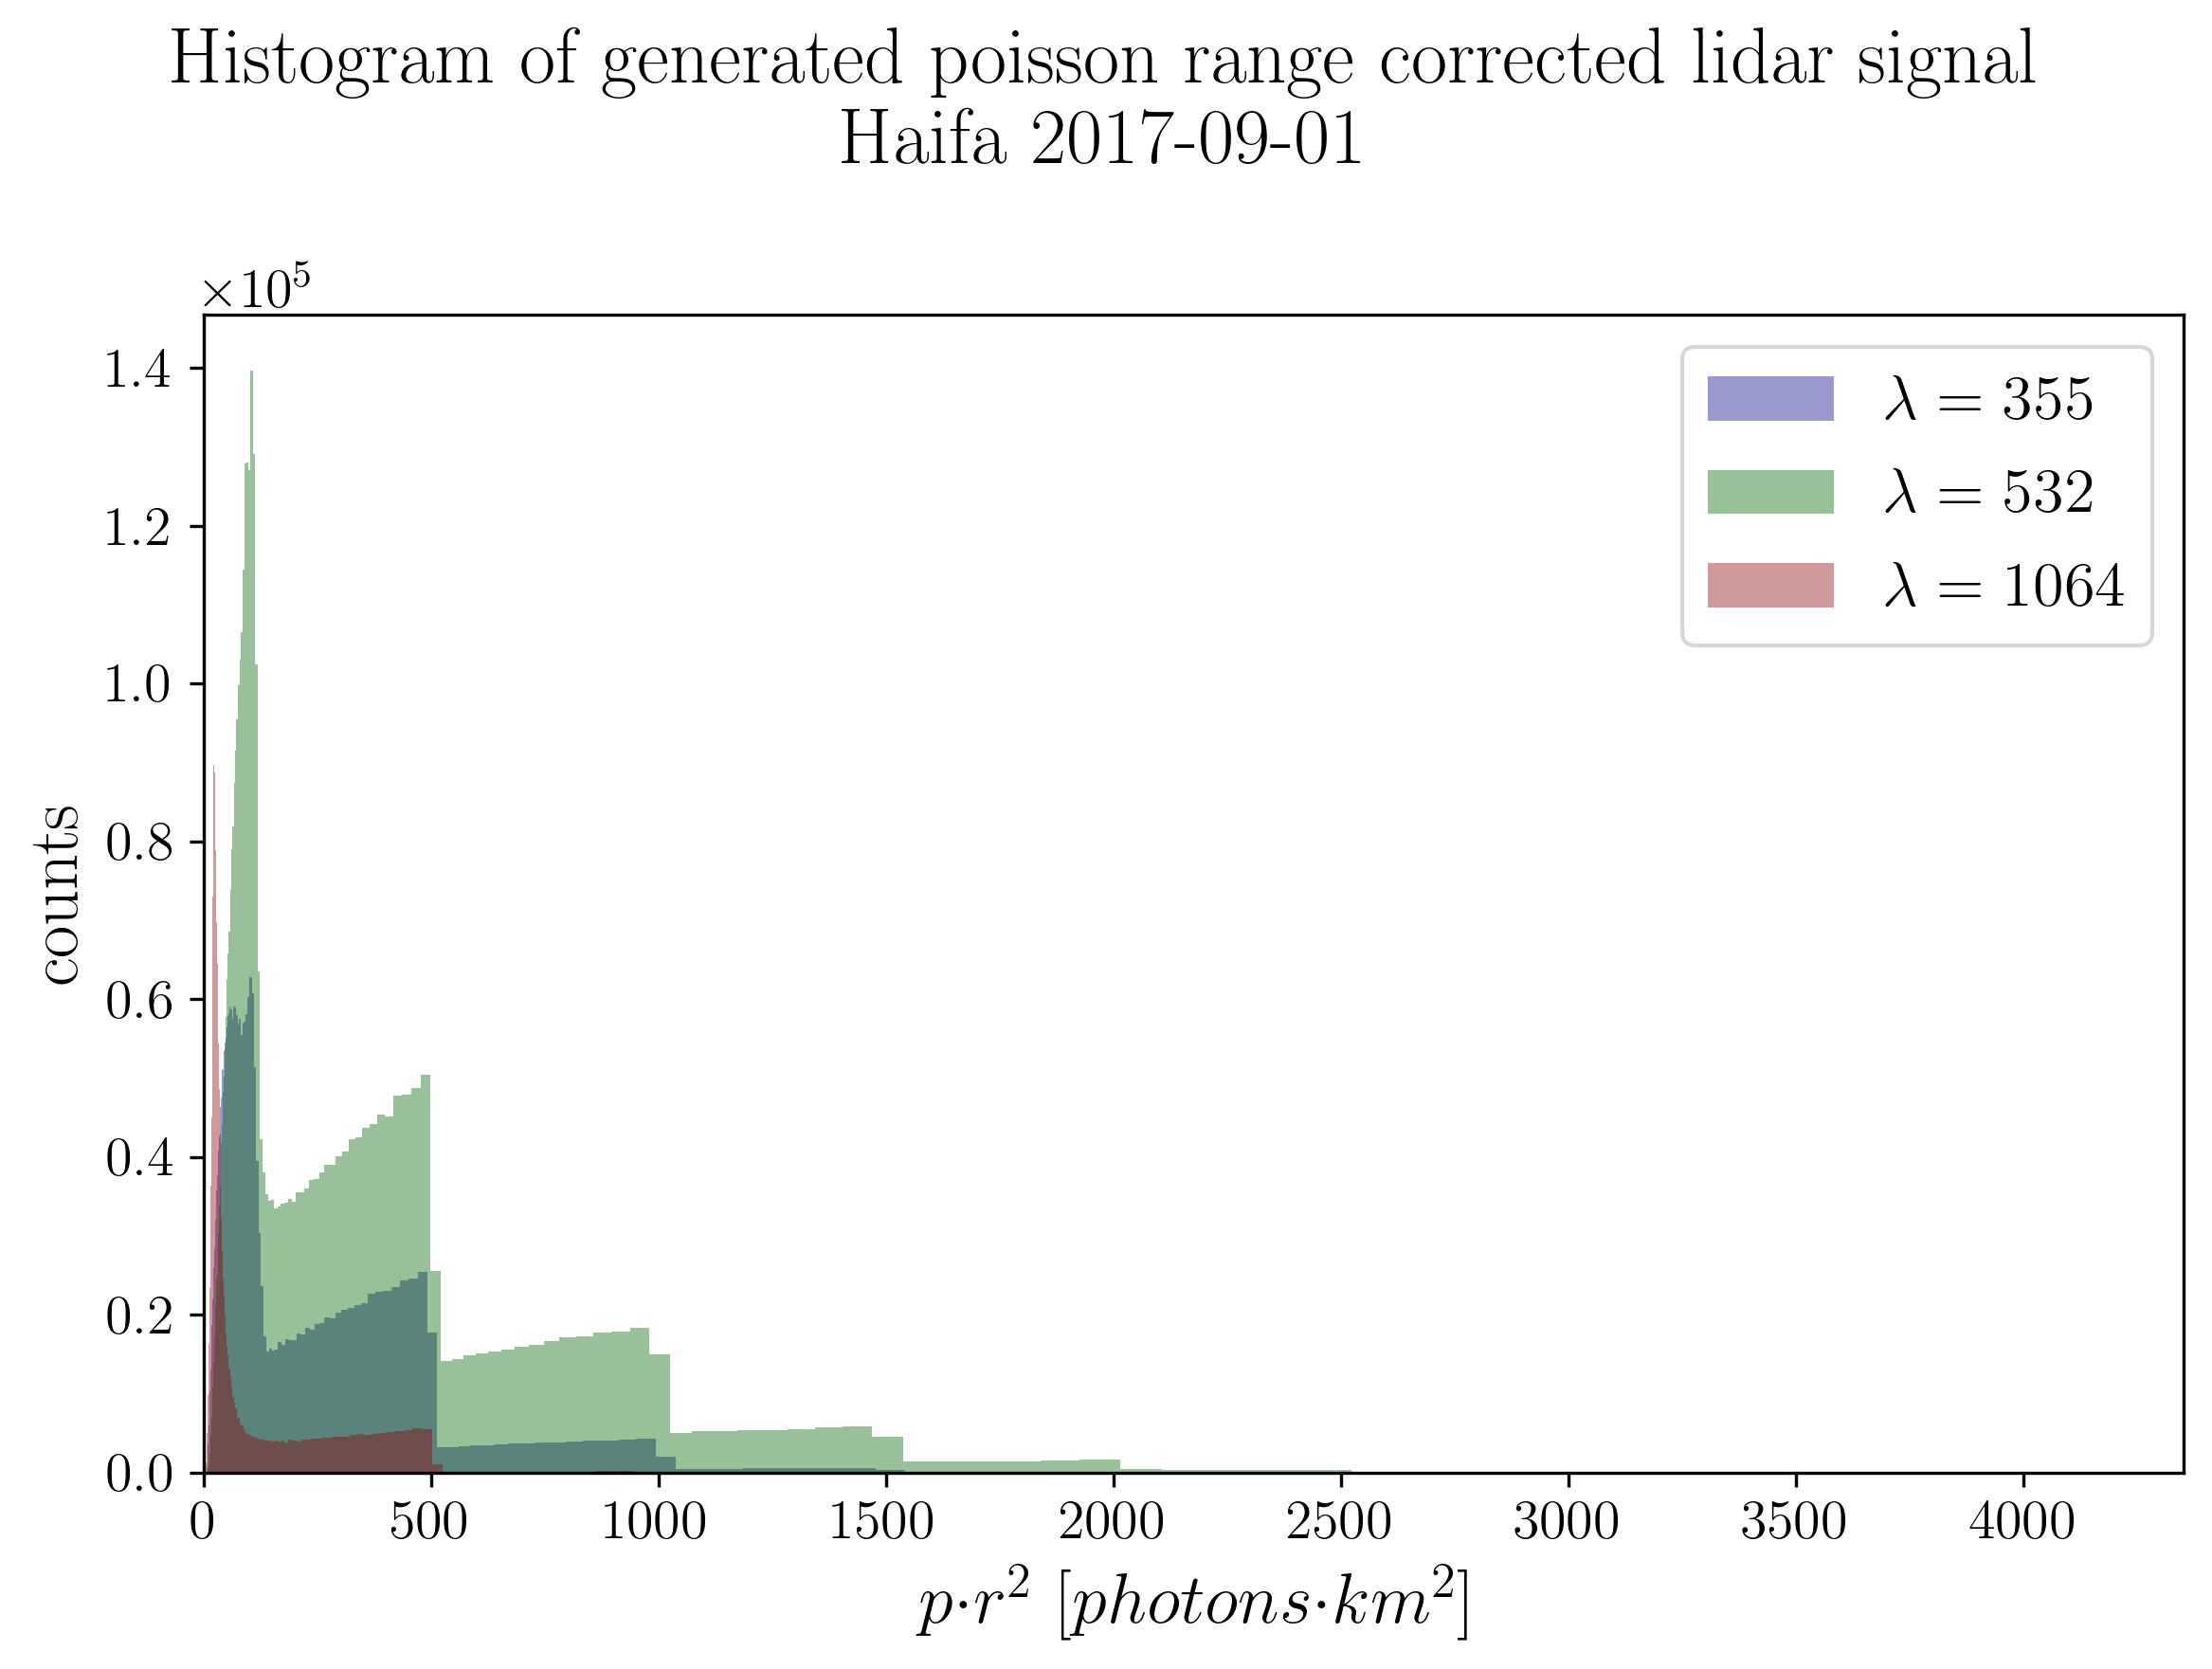

wavelength [nm]  valid size %  positive %  negative %    zeros %  \
0             355         100.0   33.364861         0.0  66.635139   
1             532         100.0   48.616736         0.0  51.383264   
2            1064         100.0   23.408796         0.0  76.591204   

                 mean                 std  
0  41.236417080767005  106.16319712914564  
1   93.91176918680877  192.21136951940645  
2  11.043028322137618   42.49478778440282

In [8]:
lidar_folder = prep.get_month_folder_name(station.gen_lidar_dataset,dt_day)
lidar_nc_name = os.path.join(lidar_folder,gen_utils.get_gen_dataset_file_name(station,dt_day,data_source='lidar'))
lidar_ds = prep.load_dataset(lidar_nc_name)
gen_utils.plot_daily_profile(lidar_ds.p,height_slice=slice(0,15), figsize=(16,6))
_,_,lidar_stats= daily_ds_histogram(lidar_ds, profile_type='p',nbins=150)#,log_scale=True)
lidar_stats

# 4. Clean range corrected Signal

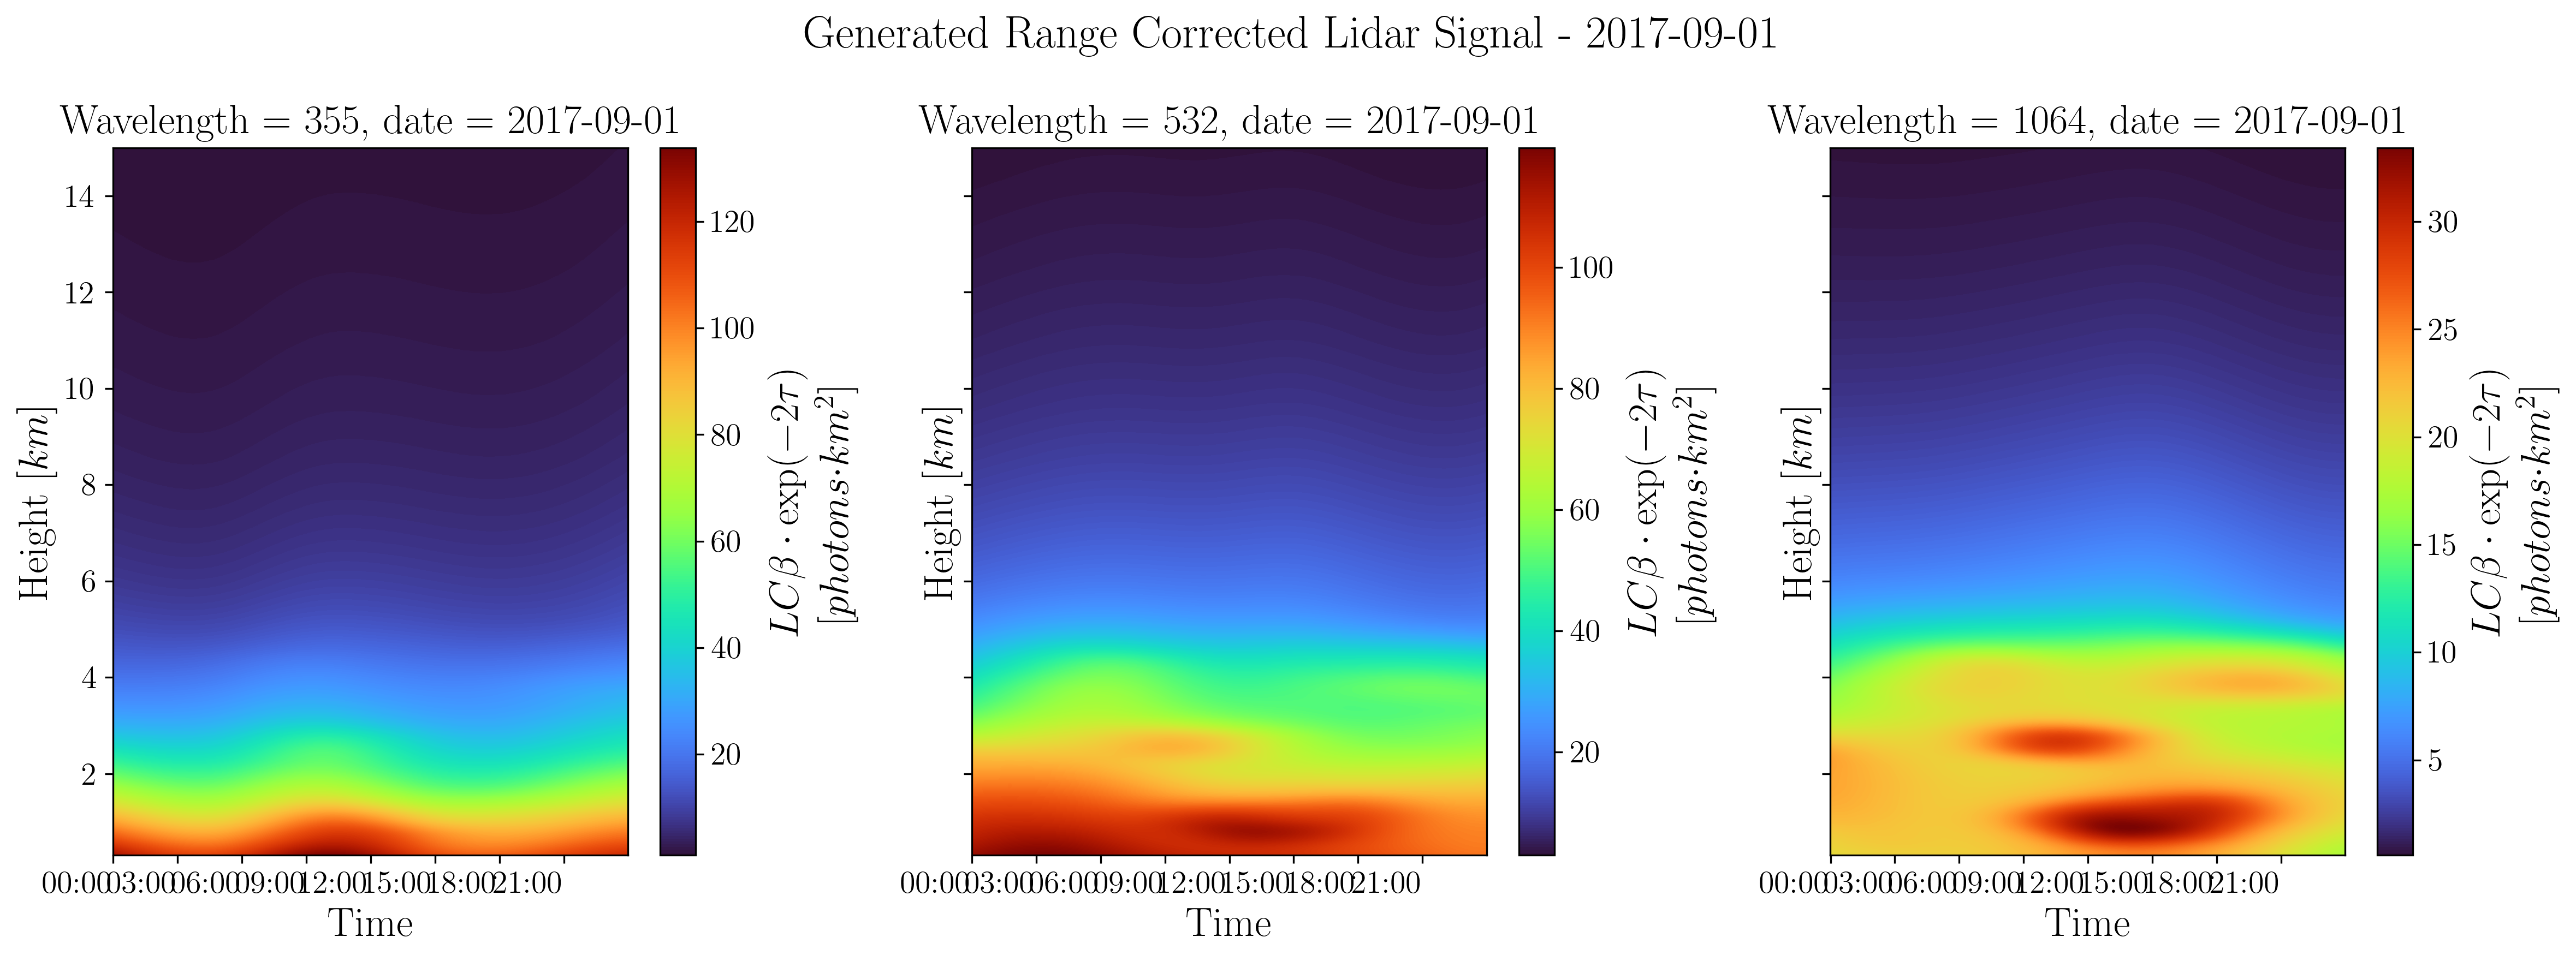

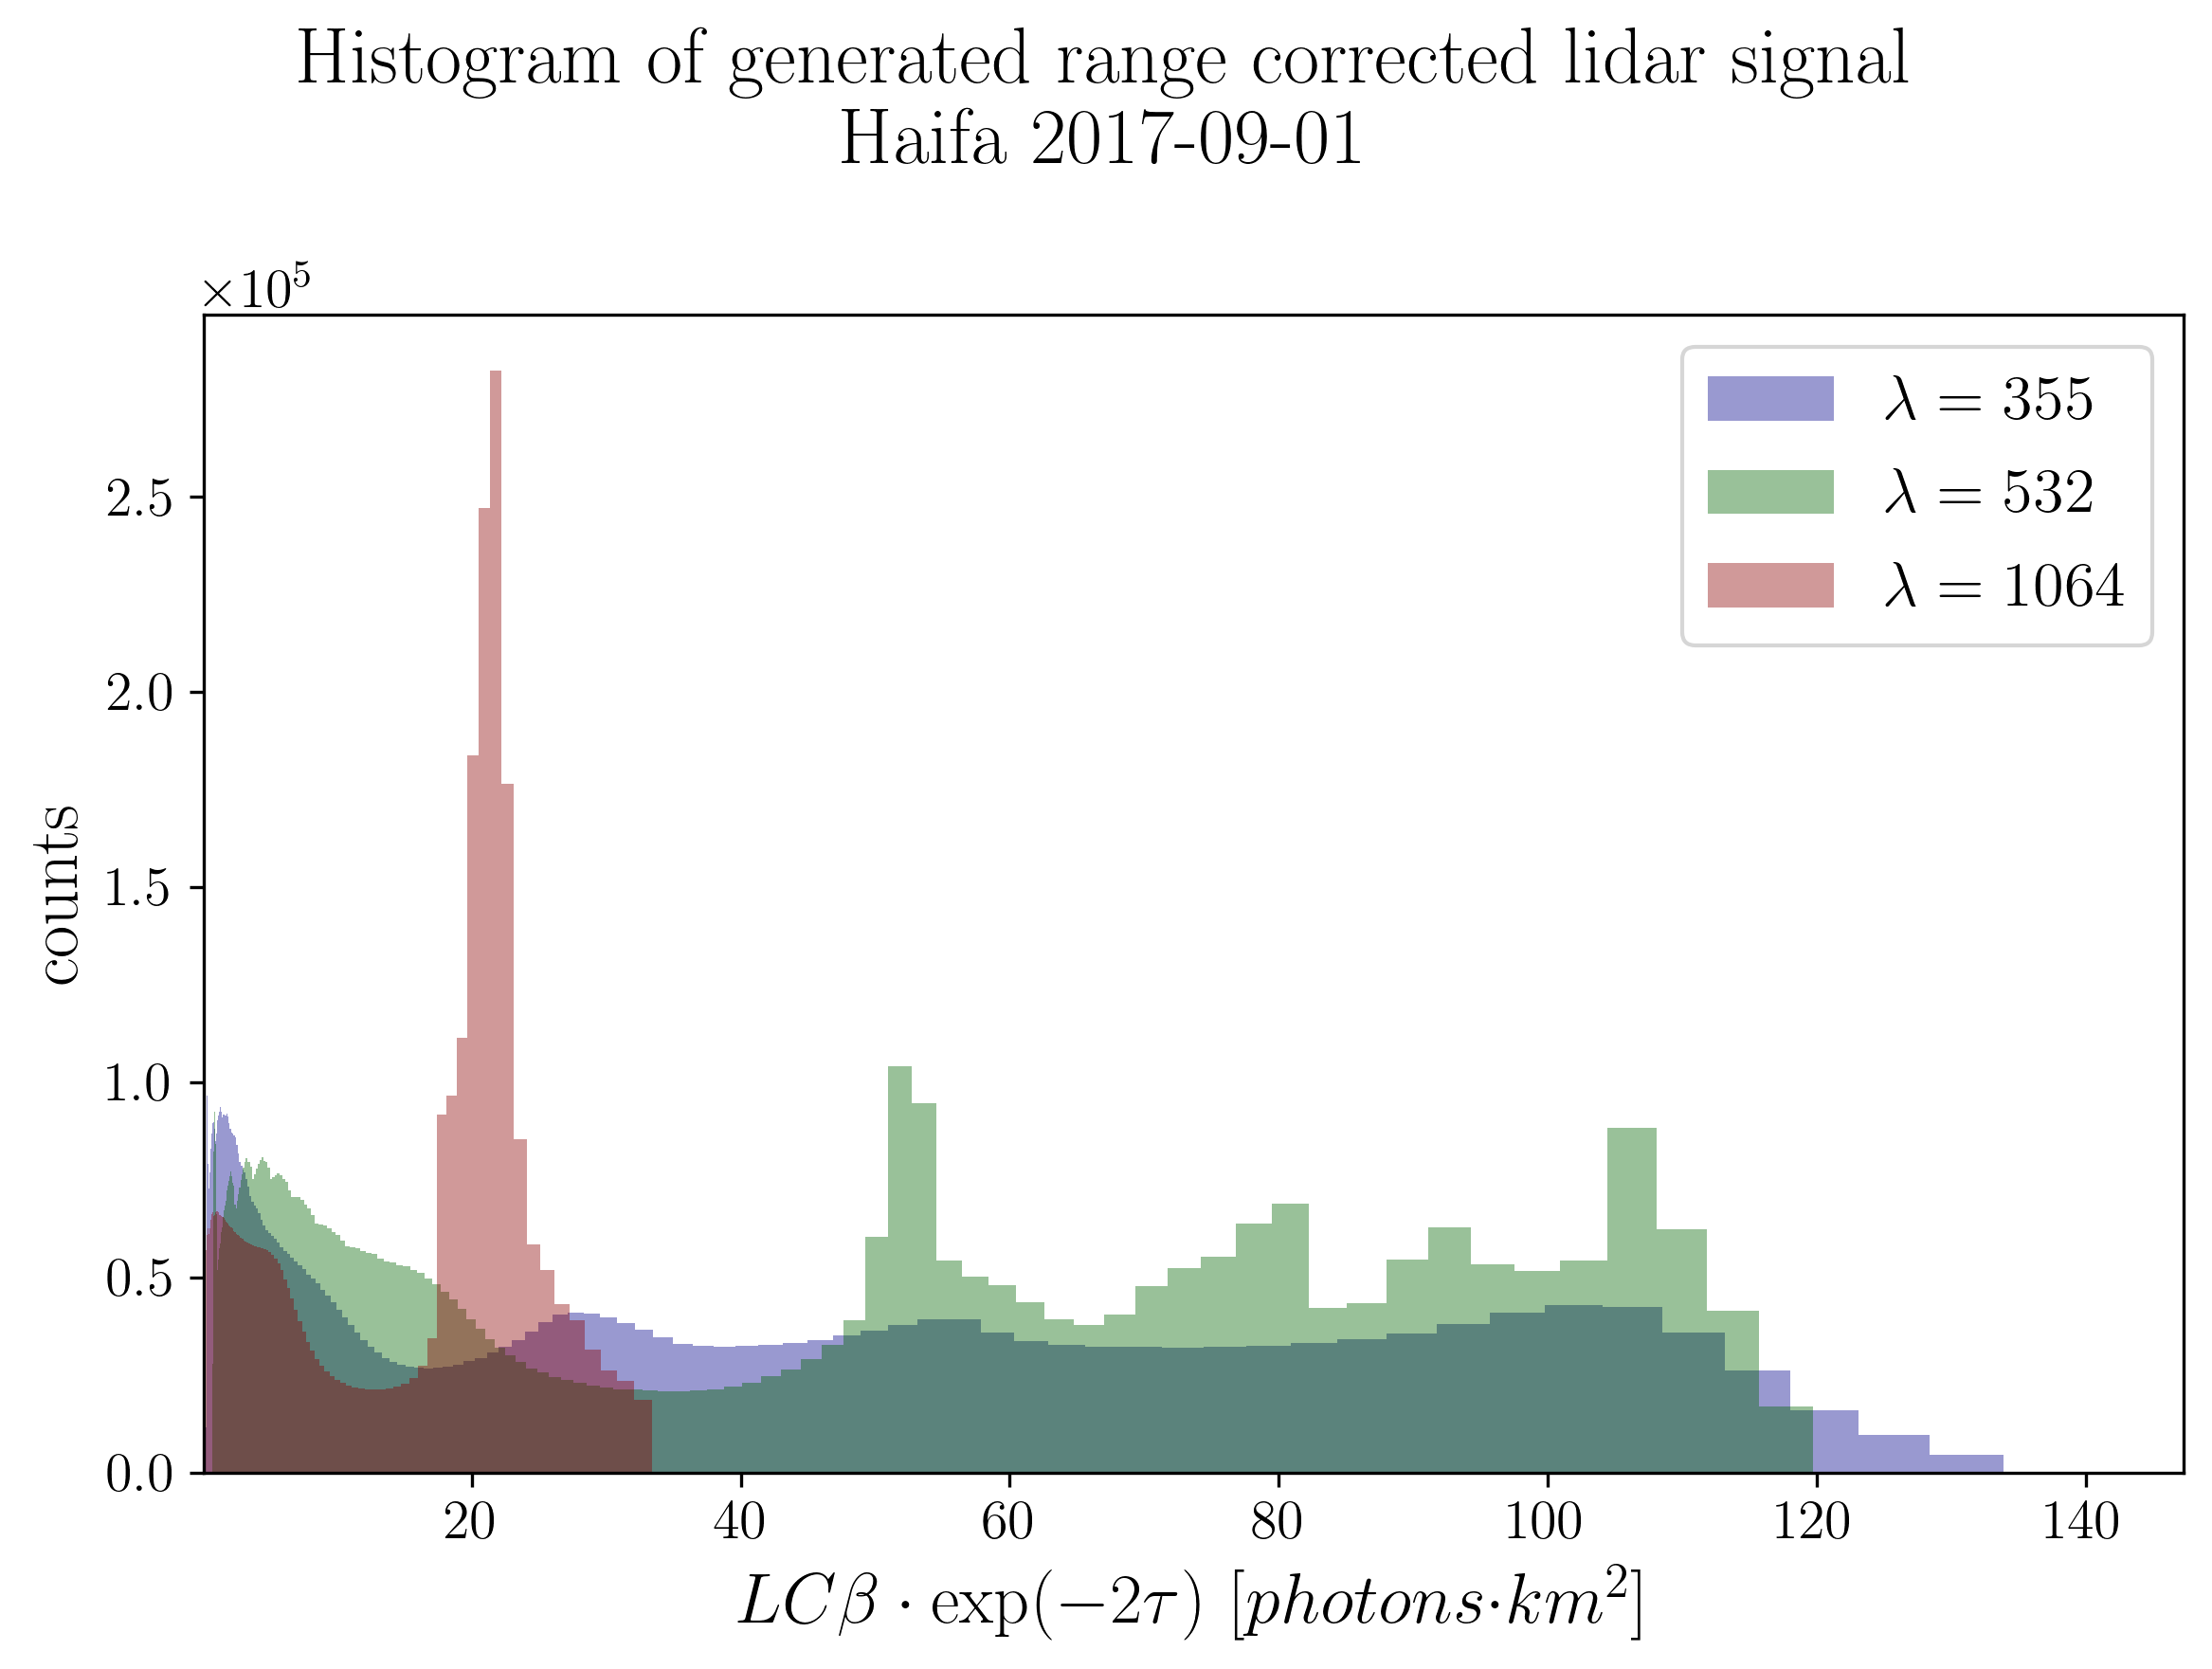

wavelength [nm]  valid size %  positive %  negative %  zeros %  \
0             355         100.0       100.0         0.0      0.0   
1             532         100.0       100.0         0.0      0.0   
2            1064         100.0       100.0         0.0      0.0   

                mean                 std  
0  12.59467625373421  24.054646512067666  
1   19.4794607290472   28.62603560340284  
2  5.901970191177061   8.278626321031364

In [9]:
gen_utils.plot_daily_profile(signal_ds.range_corr,height_slice=slice(0,15), figsize=(16,6))
_,_,pr2_stats= daily_ds_histogram(signal_ds, profile_type='range_corr',nbins=150)#,log_scale=True)
pr2_stats

# 5. Lidar range corrected measurement

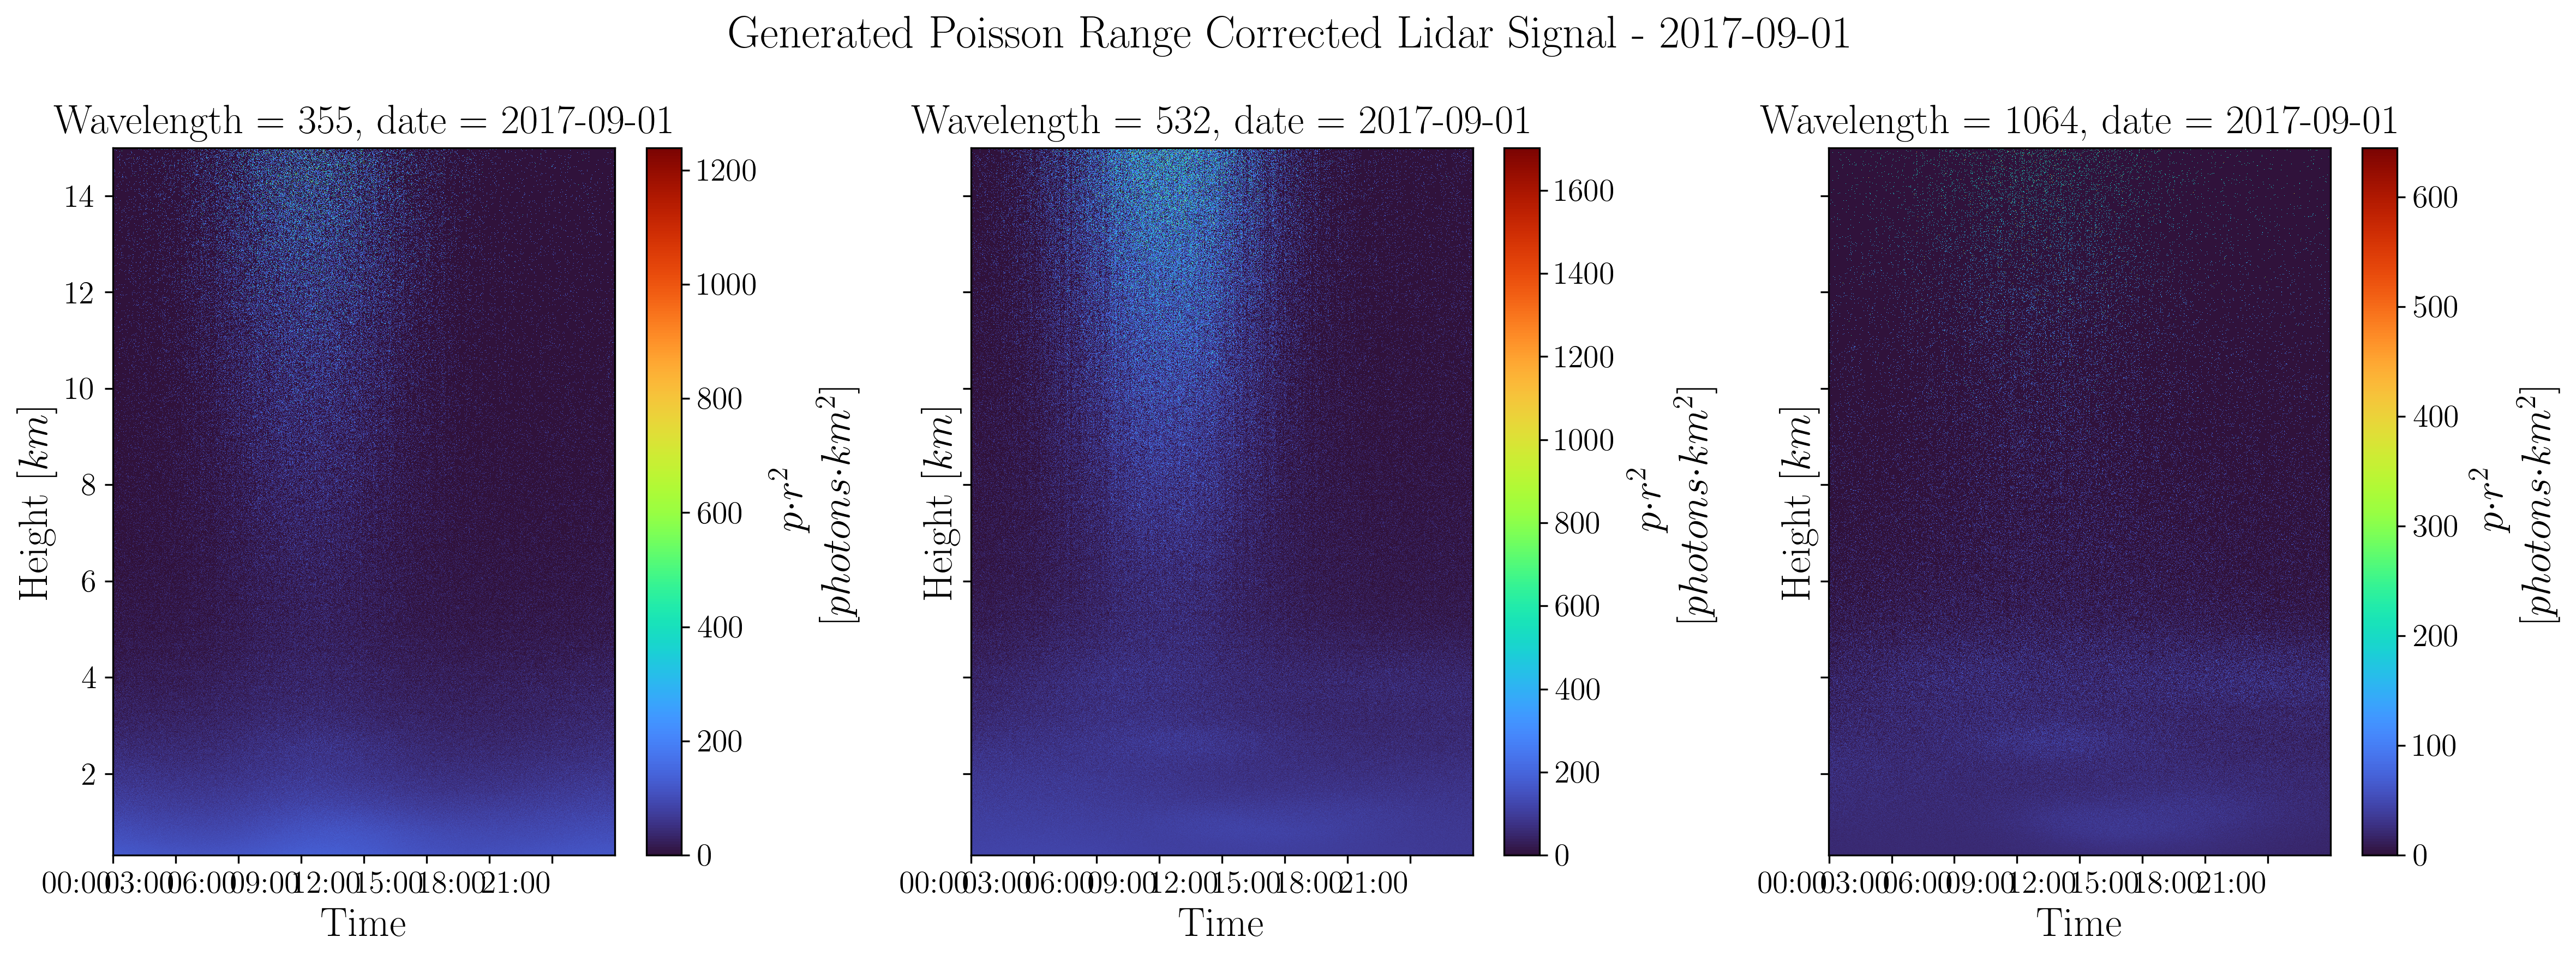

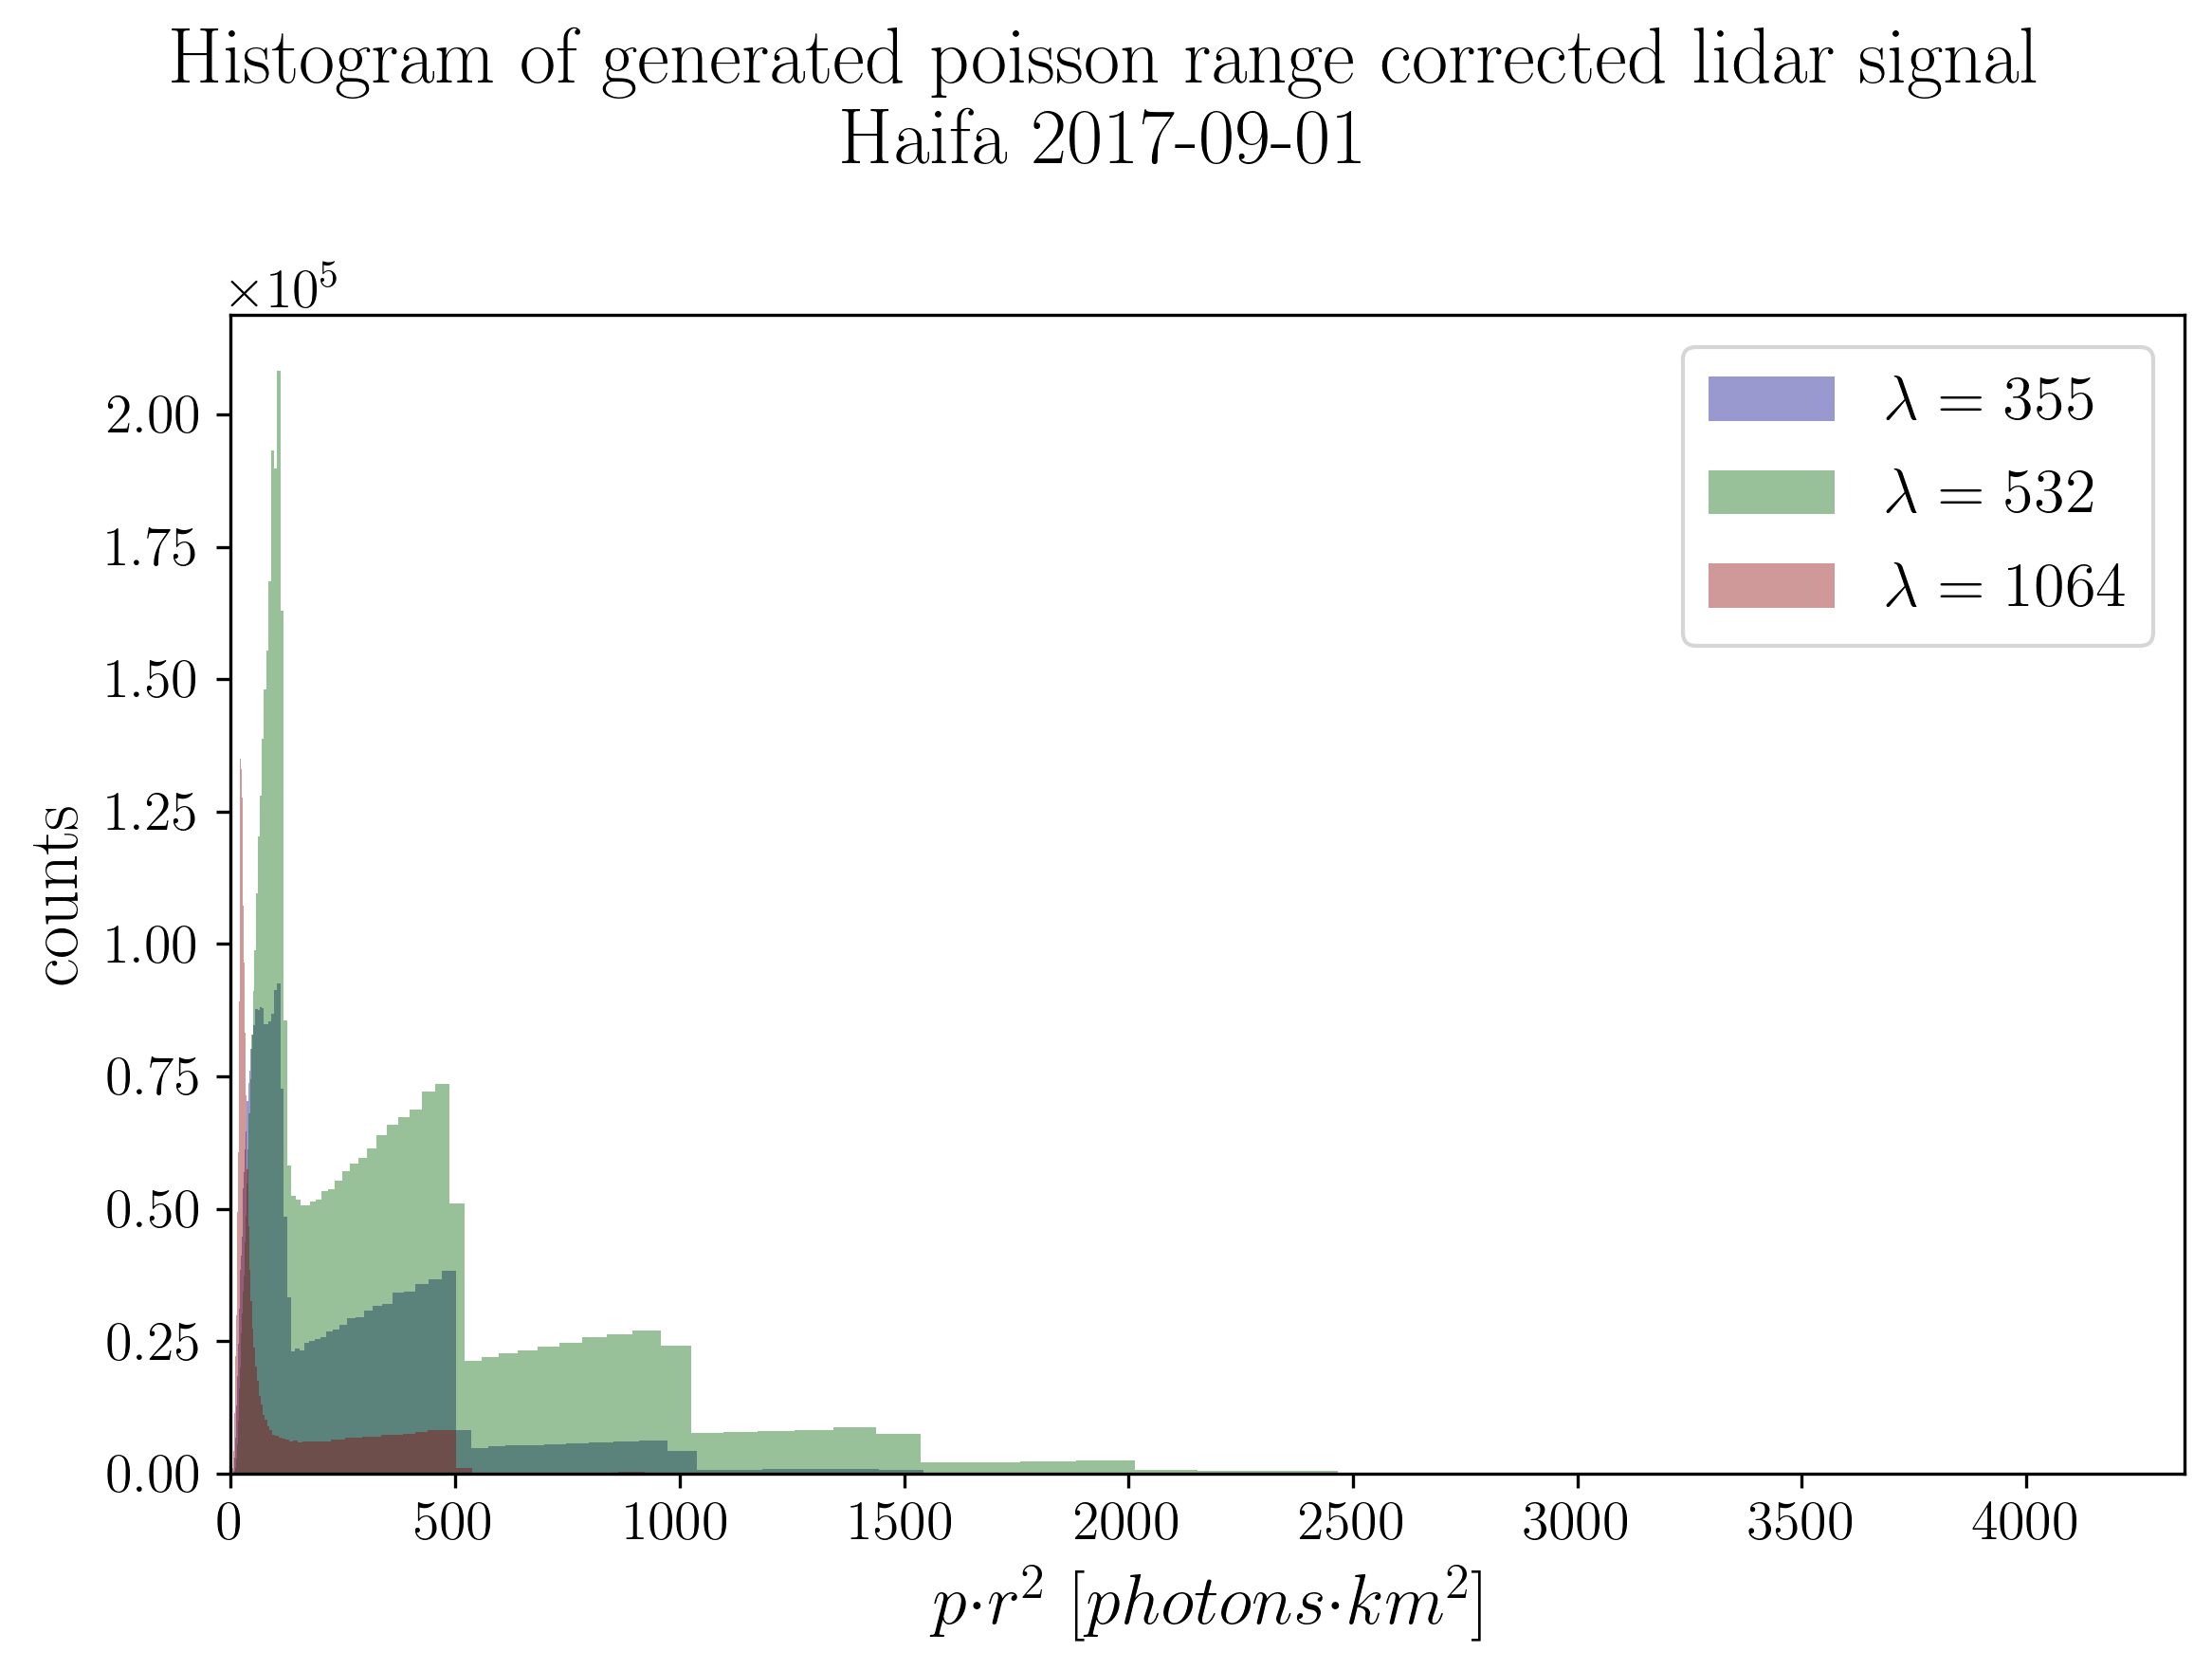

wavelength [nm]  valid size %  positive %  negative %    zeros %  \
0             355         100.0   33.364861         0.0  66.635139   
1             532         100.0   48.616736         0.0  51.383264   
2            1064         100.0   23.408796         0.0  76.591204   

                 mean                 std  
0  41.236417080767005  106.16319712914564  
1   93.91176918680877  192.21136951940645  
2  11.043028322137618   42.49478778440282

In [10]:
gen_utils.plot_daily_profile(lidar_ds.range_corr,height_slice=slice(0,15), figsize=(16,6))
_,_,pr2n_stats= daily_ds_histogram(lidar_ds, profile_type='range_corr',nbins=100)#,log_scale=True)
pr2n_stats

# 6. Molecular signal (attenuated backscatter)

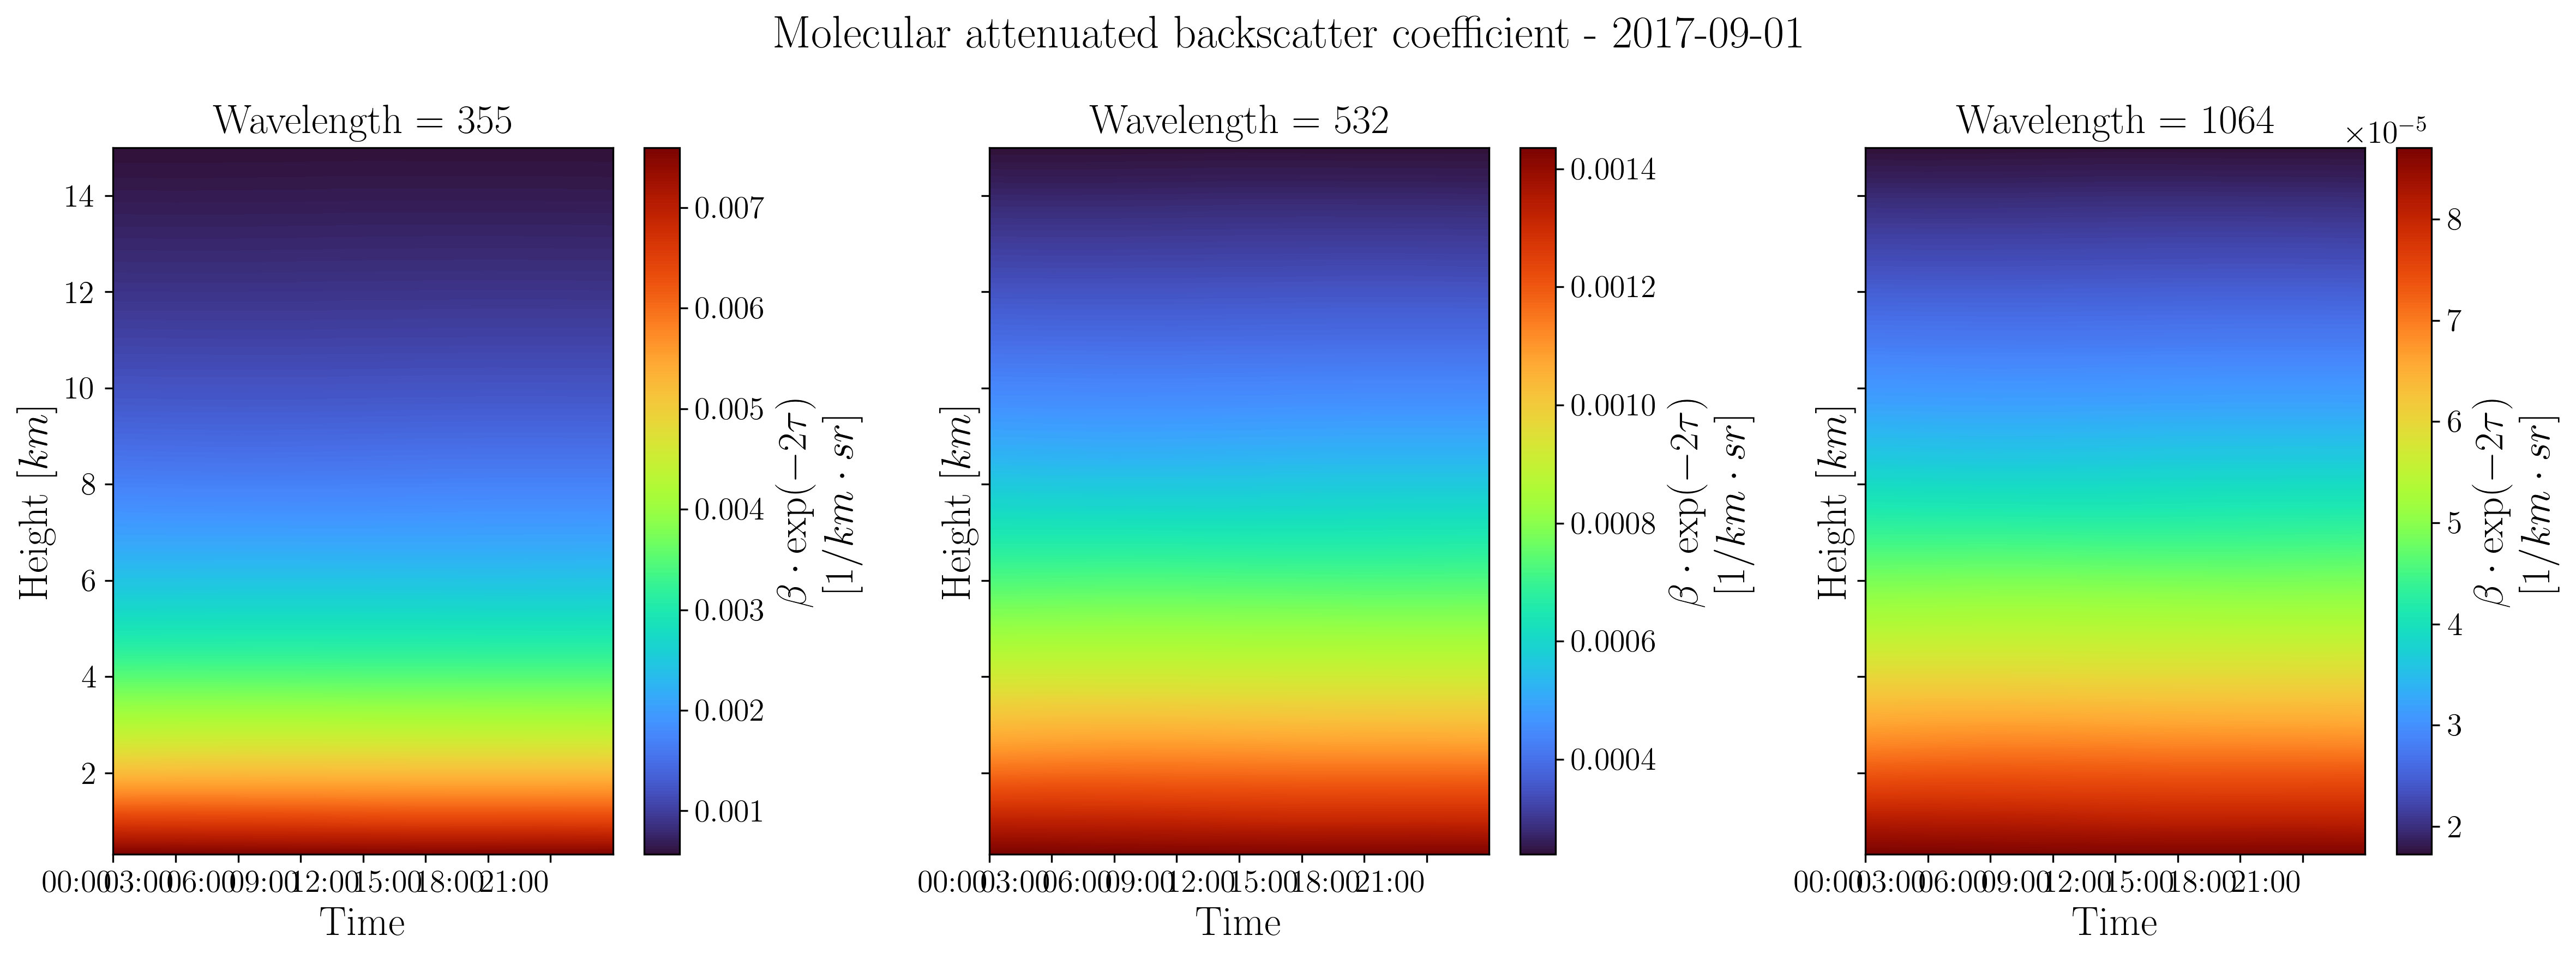

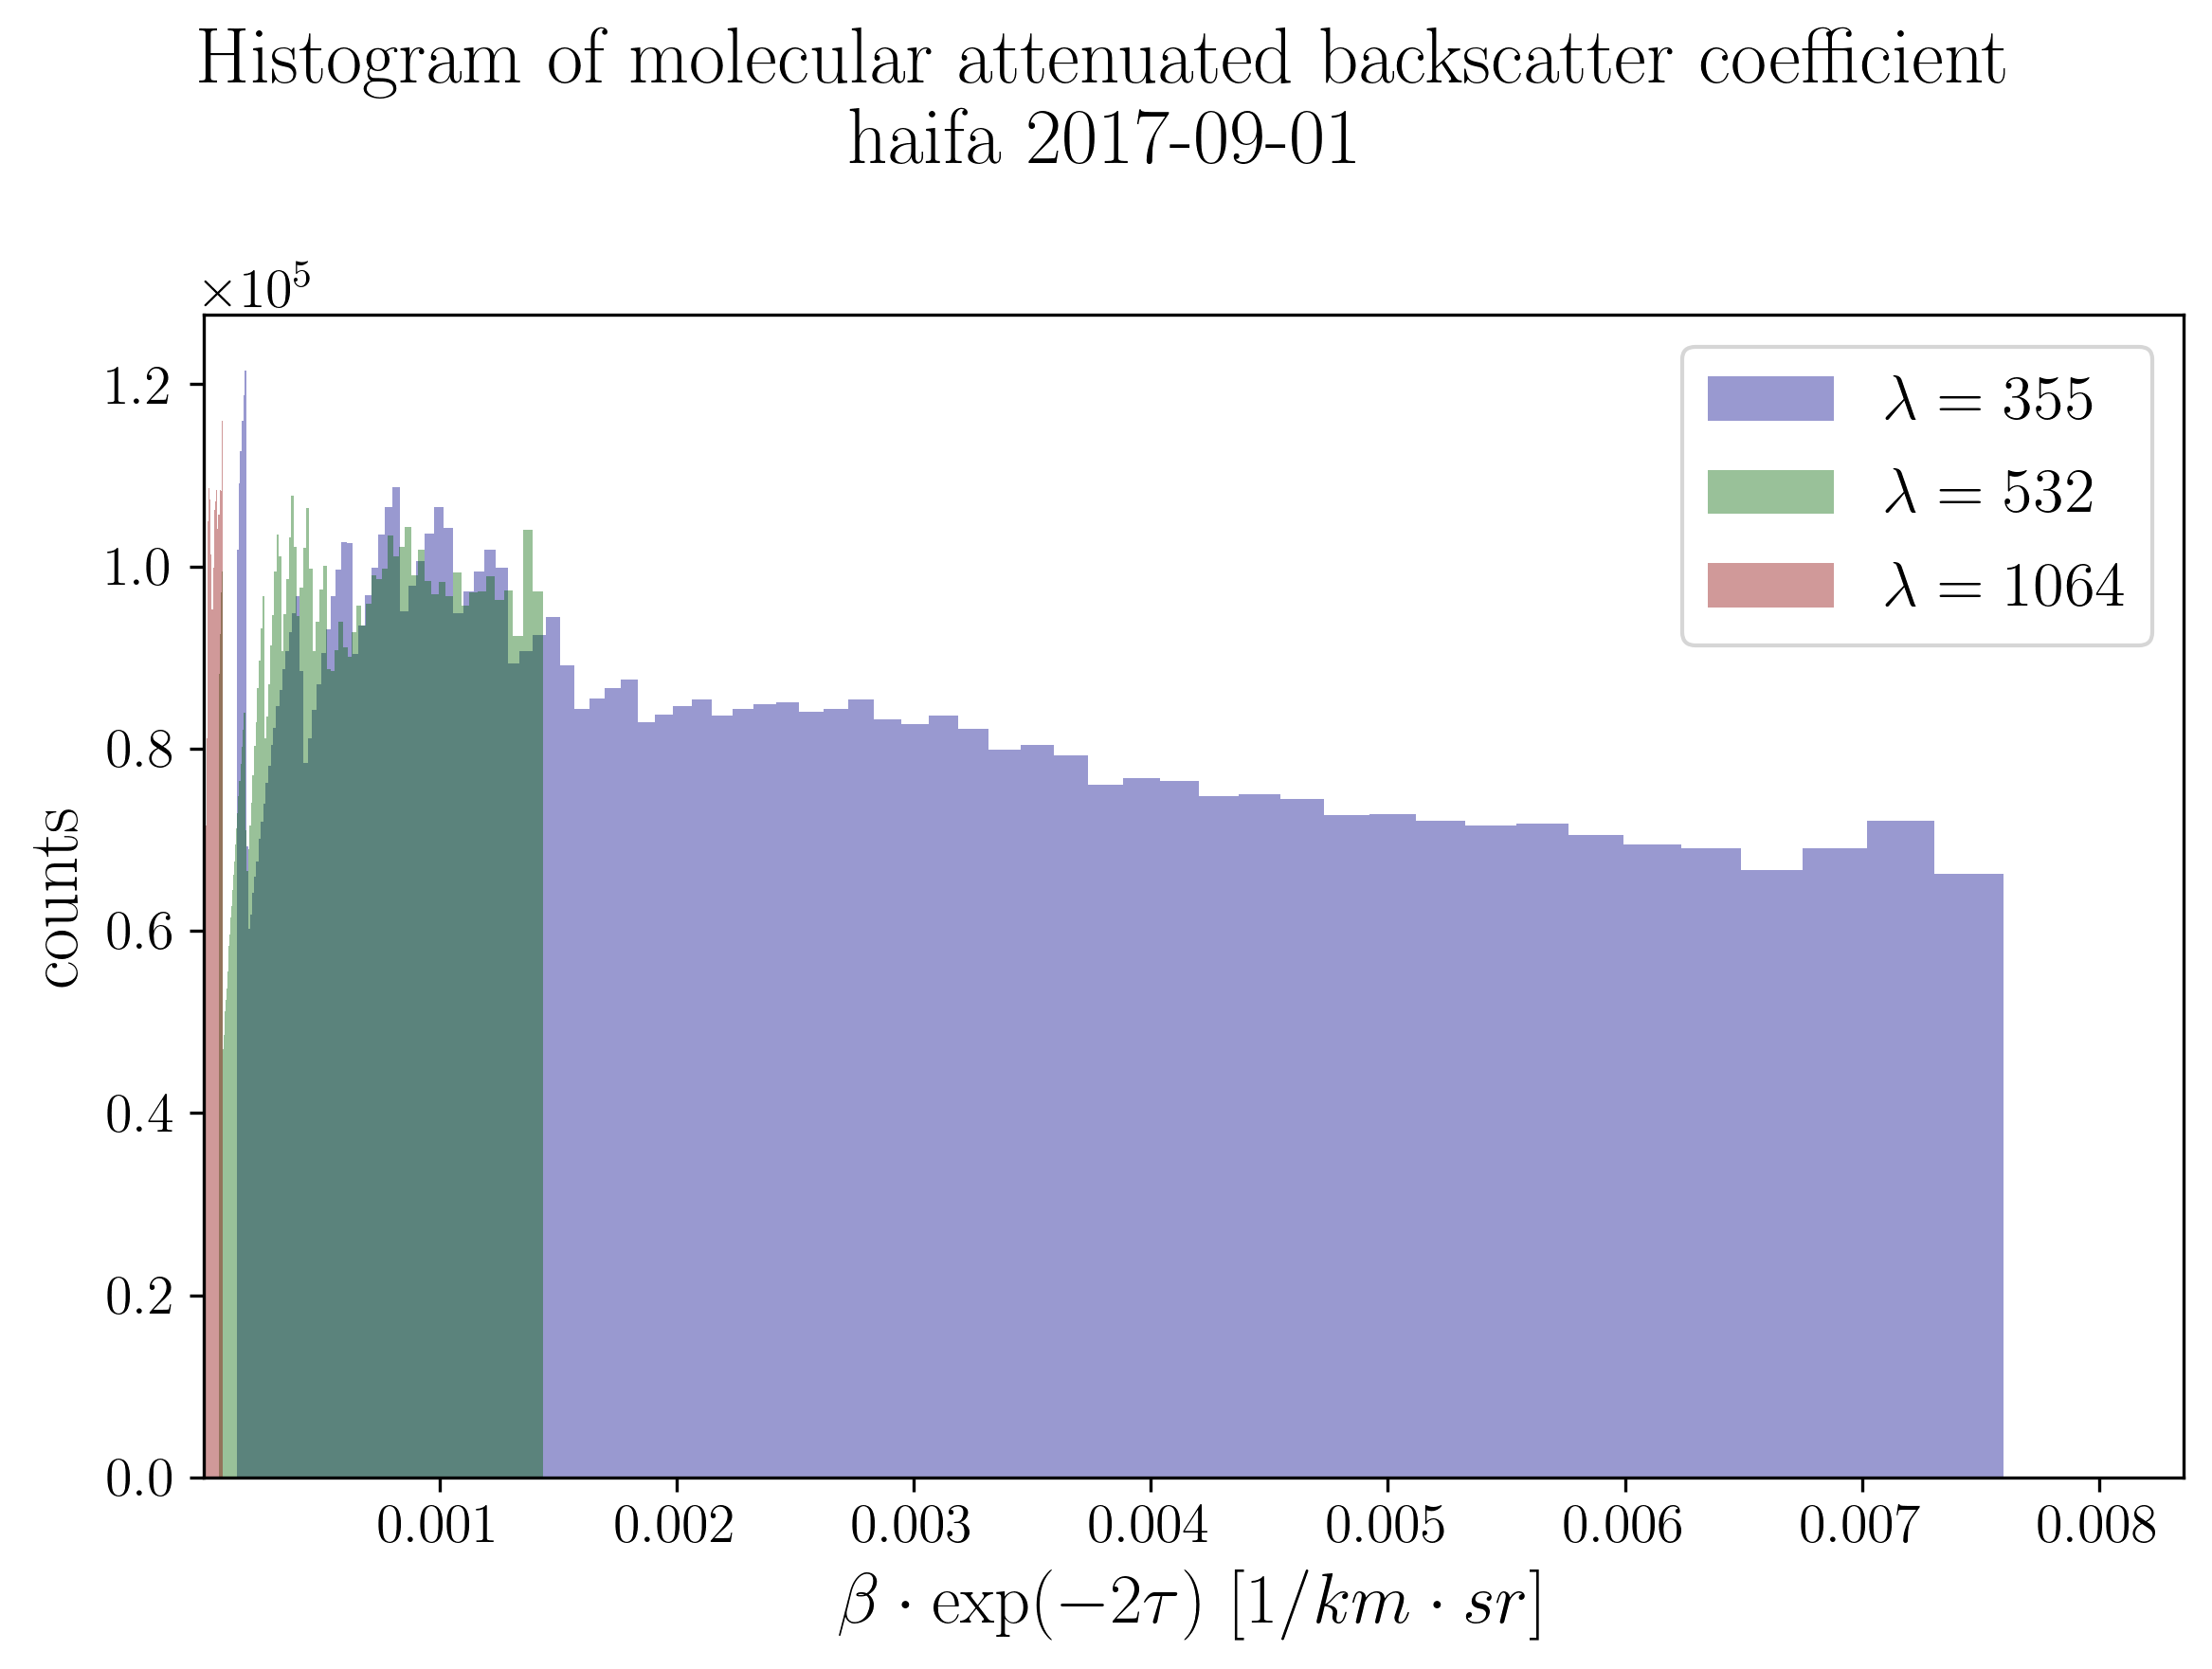

wavelength [nm]  valid size %  positive %  negative %  zeros %  \
0             355         100.0       100.0         0.0      0.0   
1             532         100.0       100.0         0.0      0.0   
2            1064         100.0       100.0         0.0      0.0   

                     mean                     std  
0    0.001734047219546154   0.0018138999150839918  
1   0.0004884187354240803   0.0003739232621597898  
2  3.2574545079182864e-05  2.3094403216912963e-05

In [11]:
mol_folder = prep.get_month_folder_name(station.molecular_dataset,dt_day)
mol_nc_name = os.path.join(mol_folder, prep.get_prep_dataset_file_name(station,dt_day,data_source='molecular',lambda_nm='all'))
mol_ds = prep.load_dataset(mol_nc_name)
gen_utils.plot_daily_profile(mol_ds.attbsc,height_slice=slice(0,15), figsize=(16,6))
_,_,mol_stats= daily_ds_histogram(mol_ds, profile_type='attbsc',nbins=100)#,log_scale=True)
mol_stats

# 7. Statistics for a period of the dataset
> Loading the statistics databse created in dataseting.py

In [9]:
start_date = datetime(2017, 9, 1)
end_date = datetime(2017, 10, 31)
#df_stats, csv_stats_path = calc_data_statistics(station, start_date, end_date)
#df_stats, csv_stats_path
stats_fname = f"stats_gen_{station.name}_{start_date.strftime('%Y-%m-%d')}_{end_date.strftime('%Y-%m-%d')}.csv"
csv_stats_path = os.path.join(data_folder, stats_fname)
df_stats = pd.read_csv(csv_stats_path)
df_stats

wavelength  p_signal_mean  p_signal_std  range_corr_signal_mean  \
0         355   224253.89180  2.503145e+06             40302.54856   
1         532   239308.93140  2.603026e+06             58955.39698   
2        1064    65135.10009  6.888914e+05             18740.05321   

   range_corr_signal_std  p_lidar_mean  p_lidar_std  range_corr_lidar_mean  \
0            78592.05014  124912.14090  346094.6026           124912.14090   
1            96839.77153  280643.77220  620156.0724           280643.77220   
2            32494.91109   33720.87374  141131.1544            33720.87374   

   range_corr_lidar_std  attbsc_molecular_mean  attbsc_molecular_std  \
0           346094.6026               6.467937              6.817075   
1           620156.0724               1.824907              1.412792   
2           141131.1544               0.121766              0.087419   

     p_bg_mean     p_bg_std       LC_mean       LC_std  
0   509.523071   569.137043  4.053180e+07  2846620.673  
1  1325.238322  1432.606017  1.227403e+08  8942864.606  
2    93.208946    99.118025  9.467285e+07  6809821.438

# 8. Exploring signals

In [ ]:
EXPLORE_GEN_DAY = False
gs.TITLE_FONT_SIZE=18

#### A. Exploring 1D generated profiles of:
- $p$
- $p\cdot r^2$
- $p_{\rm Poiss}$
- $p_{\rm Poiss}\cdot r^2$

In [ ]:
if EXPLORE_GEN_DAY:
    # 1D generated signals exploration
    Times = dt_day + np.array([timedelta(hours=5), timedelta(hours=10), timedelta(hours=15)])
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
    for t, ax in zip(Times, axes.ravel()):
        lidar_ds.range_corr.where(lidar_ds.p_mean < 50). \
            sel(Time=t, Height=slice(0, 10)).drop('date').\
            plot(ax=ax, hue='Wavelength', linestyle='--', linewidth=0.8)
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
    for t, ax in zip(Times, axes.ravel()):
        lidar_ds.p.where(lidar_ds.p_mean < 50).sel(Time=t, Height=slice(0, 10)). \
            plot(ax=ax, hue='Wavelength', linewidth=0.8, alpha=0.6)
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
    for t, ax in zip(Times, axes.ravel()):
        lidar_ds.range_corr.where(lidar_ds.p_mean < 50).sel(Time=t, Height=slice(0, 10)). \
            plot(ax=ax, hue='Wavelength', linewidth=0.8, alpha=0.6)
    plt.tight_layout()
    plt.show()

#### D. Surf plot of the signal

In [ ]:
if EXPLORE_GEN_DAY:
    # TODO: create a surf function to a given profile (e.g. measure_ds.range_corr, 'range_corr' is the name of
    #  profile),and wavelength . e.g, (532) plot 3D surf figure
    # TODO: xarray didn't implemented surf plot -
    wavelength = 532
    X = np.arange(0, station.total_time_bins, 1)
    th = 12.0
    Y = lidar_ds.range_corr.Height.sel(Height=slice(0, th)).values
    X, Y = np.meshgrid(X, Y)
    Z = lidar_ds.range_corr.sel(Wavelength=wavelength, Height=slice(0, th)).values
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='turbo',
                           linewidth=0.1, rstride=5, alpha=.5,
                           cstride=5, antialiased=False)
    ax.set_ylabel('Height')
    ax.set_xlabel('Time')
    ax.set_zlabel('Density')
    plt.colorbar(surf, ax=ax, shrink=0.9, aspect=5)
    ax.view_init(30, 10)
    plt.show()

#### C. Exploring up-sampled and down-sampled data to check the "stairs" effect of multiplying / dividing by $r^2$
Testing: $p = \frac {LC_{\rm generated}\cdot\beta_{\rm attbsc}}{r^2}$
 - Upsampling / downsampling ${LC_{\rm generated}\cdot\beta_{\rm attbsc}}$
 - Calculating $p = \frac {LC_{\rm generated}\cdot\beta_{\rm attbsc}}{\hat r^2}$
 - Where:
    - for up-sample case: $\hat r = \frac{1}{2}\cdot r$
    - for down-sample case: $\hat r = 2\cdot r$

In [ ]:
if EXPLORE_GEN_DAY:
    wavelengths = gs.LAMBDA_nm().get_elastic()
    heights = station.calc_height_index()
    # up-sampled signal exploration
    start_h = heights[0]
    end_h = heights[-1]
    scale = 0.25
    new_height_size = int(station.n_bins / scale)
    new_heights = np.linspace(start=start_h, stop=end_h, num=new_height_size, endpoint=True)

    temp = xr.DataArray(np.zeros((new_height_size, station.total_time_bins, len(wavelengths))),
                        [("Height", new_heights), ("Time", signal_ds.range_corr.Time.values),
                         ("Wavelength", signal_ds.range_corr.Wavelength.values)])
    up_pr2d = signal_ds.range_corr.interp_like(temp, method='linear')

    # 2D plot of up-sampled range corrected
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
    for wavelength, ax in zip(wavelengths, axes.ravel()):
        up_pr2d.sel(Wavelength=wavelength).plot(cmap='turbo', ax=ax)
    plt.tight_layout()
    plt.show()

#### D. Explore measurements and parameters for the chosen day
1. Load extended calibration database for signal exploration
2. Create daily calibration dataset
3. Visualise typical parameters of measured day as: $LC$, $r_m$ ,$r_0$,$r_1$

In [ ]:
from learning_lidar.generation.daily_signals_generations_utils import explore_orig_day
EXPLORE_ORIG_DAY = False
if EXPLORE_ORIG_DAY:
    time_indx = station.calc_daily_time_index(dt_day)
    explore_orig_day(main_folder=main_folder,
                     station_name=station.name,
                     start_date=start_date,
                     end_date=end_date,
                     cur_day=dt_day,
                     timedelta=timedelta,
                     wavelengths=wavelengths,
                     time_indx=time_indx)